# CL-DA-Project3-1

# Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import copy
import math

import sqlite3

import itertools as it

from scipy.stats import chisquare
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sb 

path = ''  # путь пустой, т.к. исходный файл с базой данных был загружен непосредственно в notebook
database = path + 'database.sqlite'


# Функции

###  Функция, проверяющая процент пропущенных данных в столбцах датафрейма

In [2]:
def na_ratio(df):
    na_dict = {}

    for i in df.columns:
        na_dict[i] = sum(df[i].isna())/len(df[i])

    na_per_column = pd.DataFrame(index = na_dict.keys(), data = {'na_ratio': na_dict.values()})

    return na_per_column.sort_values(by='na_ratio', ascending=False)

### Функция, показывающая список "плохих" факторов

In [3]:
def na_borderline_factors(na_ratio_df, borderline):
    na_borderline = borderline
    factors = list(na_ratio_df[na_ratio_df['na_ratio']>na_borderline].index)

    return factors

# Импорт и просмотр данных


### Создадим связку с базой данных, чтобы посмотреть, какие датафреймы у нас есть

In [4]:
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

In [5]:
conn = sqlite3.connect(database)

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

type               name           tbl_name  rootpage  \
0  table    sqlite_sequence    sqlite_sequence         4   
1  table  Player_Attributes  Player_Attributes        11   
2  table             Player             Player        14   
3  table              Match              Match        18   
4  table             League             League        24   
5  table            Country            Country        26   
6  table               Team               Team        29   
7  table    Team_Attributes    Team_Attributes         2   

                                                 sql  
0             CREATE TABLE sqlite_sequence(name,seq)  
1  CREATE TABLE "Player_Attributes" (\n\t`id`\tIN...  
2  CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...  
3  CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...  
4  CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...  
5  CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...  
6  CREATE TABLE "Team" (\n\t`id`\tINTEGER PRIMARY...  
7  CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...

### Запишем датафреймы в понятные переменные и посмотрим на имеющиеся в них данные

In [6]:
countries = pd.read_sql("""SELECT *
                        FROM Country;""", conn)
countries

id         name
0       1      Belgium
1    1729      England
2    4769       France
3    7809      Germany
4   10257        Italy
5   13274  Netherlands
6   15722       Poland
7   17642     Portugal
8   19694     Scotland
9   21518        Spain
10  24558  Switzerland

In [7]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 308.0+ bytes


Здесь у нас маленький датафрейм без пропусков - предобработка не нужна.

In [8]:
leagues = pd.read_sql("""SELECT *
                        FROM League""", conn)
leagues

id  country_id                      name
0       1           1    Belgium Jupiler League
1    1729        1729    England Premier League
2    4769        4769            France Ligue 1
3    7809        7809     Germany 1. Bundesliga
4   10257       10257             Italy Serie A
5   13274       13274    Netherlands Eredivisie
6   15722       15722        Poland Ekstraklasa
7   17642       17642  Portugal Liga ZON Sagres
8   19694       19694   Scotland Premier League
9   21518       21518           Spain LIGA BBVA
10  24558       24558  Switzerland Super League

In [9]:
leagues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 396.0+ bytes


Еще один небольшой датафрейм без пропусков, не требующий дополнительной предобработки.

In [10]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name""", conn)
teams

id  team_api_id  team_fifa_api_id            team_long_name  \
0    16848         8350              29.0      1. FC Kaiserslautern   
1    15624         8722              31.0                1. FC Köln   
2    16239         8165             171.0            1. FC Nürnberg   
3    16243         9905             169.0           1. FSV Mainz 05   
4    11817         8576             614.0                AC Ajaccio   
..     ...          ...               ...                       ...   
294  43800         9868            1742.0      Xerez Club Deportivo   
295  31928         8021          110749.0            Zagłębie Lubin   
296  33855         8027          112512.0         Zawisza Bydgoszcz   
297  11822         4087          111271.0  Évian Thonon Gaillard FC   
298  31449         8025          111092.0             Śląsk Wrocław   

    team_short_name  
0               KAI  
1               FCK  
2               NUR  
3               MAI  
4               AJA  
..              ...  
294             XER  
295             ZAG  
296             ZAW  
297             ETG  
298             SLA  

[299 rows x 5 columns]

In [11]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


Видим, что в столбце team_fifa_api_id есть пропущенные значения.

Посмотрим эти строчки.

In [12]:
teams[pd.isnull(teams).any(axis=1)]

id  team_api_id  team_fifa_api_id                team_long_name  \
16   35291        10213               NaN                       Amadora   
99   26561         6601               NaN                   FC Volendam   
101      9         7947               NaN                 FCV Dender EH   
103  36723         4064               NaN                      Feirense   
160  51606         7896               NaN                        Lugano   
195  36248         9765               NaN                  Portimonense   
261  34816       177361               NaN  Termalica Bruk-Bet Nieciecza   
262  38791       188163               NaN                       Tondela   
266  35286         7992               NaN                      Trofense   
267     15         4049               NaN                        Tubize   
272  38789         6367               NaN              Uniao da Madeira   

    team_short_name  
16              AMA  
99              VOL  
101             DEN  
103             FEI  
160             LUG  
195             POR  
261             TBN  
262             TON  
266             TRO  
267             TUB  
272             MAD

Скорее всего данные команды просто не представленны в fifa. Удалять строки не будем, т.к. каждая обозначает уникальную команду.

Возможно нам не понадобится сам столбец team_fifa_api_id в будущем. Пока оставим его и посмотрим на другие датафреймы.

In [13]:
team_attributes = pd.read_sql("""SELECT *
                        FROM Team_Attributes""", conn)
team_attributes

id  team_fifa_api_id  team_api_id                 date  \
0        1               434         9930  2010-02-22 00:00:00   
1        2               434         9930  2014-09-19 00:00:00   
2        3               434         9930  2015-09-10 00:00:00   
3        4                77         8485  2010-02-22 00:00:00   
4        5                77         8485  2011-02-22 00:00:00   
...    ...               ...          ...                  ...   
1453  1454             15005        10000  2011-02-22 00:00:00   
1454  1455             15005        10000  2012-02-22 00:00:00   
1455  1456             15005        10000  2013-09-20 00:00:00   
1456  1457             15005        10000  2014-09-19 00:00:00   
1457  1458             15005        10000  2015-09-10 00:00:00   

      buildUpPlaySpeed buildUpPlaySpeedClass  buildUpPlayDribbling  \
0                   60              Balanced                   NaN   
1                   52              Balanced                  48.0   
2                   47              Balanced                  41.0   
3                   70                  Fast                   NaN   
4                   47              Balanced                   NaN   
...                ...                   ...                   ...   
1453                52              Balanced                   NaN   
1454                54              Balanced                   NaN   
1455                54              Balanced                   NaN   
1456                54              Balanced                  42.0   
1457                54              Balanced                  42.0   

     buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                       Little                  50                   Mixed   
1                       Normal                  56                   Mixed   
2                       Normal                  54                   Mixed   
3                       Little                  70                    Long   
4                       Little                  52                   Mixed   
...                        ...                 ...                     ...   
1453                    Little                  52                   Mixed   
1454                    Little                  51                   Mixed   
1455                    Little                  51                   Mixed   
1456                    Normal                  51                   Mixed   
1457                    Normal                  51                   Mixed   

     buildUpPlayPositioningClass  chanceCreationPassing  \
0                      Organised                     60   
1                      Organised                     54   
2                      Organised                     54   
3                      Organised                     70   
4                      Organised                     53   
...                          ...                    ...   
1453                   Organised                     52   
1454                   Organised                     47   
1455                   Organised                     47   
1456                   Organised                     47   
1457                   Organised                     47   

     chanceCreationPassingClass  chanceCreationCrossing  \
0                        Normal                      65   
1                        Normal                      63   
2                        Normal                      63   
3                         Risky                      70   
4                        Normal                      48   
...                         ...                     ...   
1453                     Normal                      48   
1454                     Normal                      52   
1455                     Normal                      52   
1456                     Normal                      52   
1457                     Normal                      52   

     chanceCreation

In [14]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

Видим, что большинство данных не содержит пропусков, кроме столбца buildUpPlayDribbling.
В столбце отсутствует почти 70% данных, так что придется им пожертвовать и дропнуть.

In [15]:
team_attributes = team_attributes.drop(['buildUpPlayDribbling'], axis=1)


In [16]:
# Преобразуем столбец с датой в формат без времени
team_attributes['date'] = pd.to_datetime(team_attributes['date'])

In [17]:
team_attributes.isnull().sum().sum()

0

In [18]:
players = pd.read_sql("""SELECT *
                        FROM Player;""", conn)
players

id  player_api_id          player_name  player_fifa_api_id  \
0          1         505942   Aaron Appindangoye              218353   
1          2         155782      Aaron Cresswell              189615   
2          3         162549          Aaron Doran              186170   
3          4          30572        Aaron Galindo              140161   
4          5          23780         Aaron Hughes               17725   
...      ...            ...                  ...                 ...   
11055  11071          26357       Zoumana Camara                2488   
11056  11072         111182         Zsolt Laczko              164680   
11057  11073          36491            Zsolt Low              111191   
11058  11074          35506  Zurab Khizanishvili               47058   
11059  11075          39902   Zvjezdan Misimovic              102359   

                  birthday  height  weight  
0      1992-02-29 00:00:00  182.88     187  
1      1989-12-15 00:00:00  170.18     146  
2      1991-05-13 00:00:00  170.18     163  
3      1982-05-08 00:00:00  182.88     198  
4      1979-11-08 00:00:00  182.88     154  
...                    ...     ...     ...  
11055  1979-04-03 00:00:00  182.88     168  
11056  1986-12-18 00:00:00  182.88     176  
11057  1979-04-29 00:00:00  180.34     154  
11058  1981-10-06 00:00:00  185.42     172  
11059  1982-06-05 00:00:00  180.34     176  

[11060 rows x 7 columns]

In [19]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


Видим, что в датафрейме с игроками пропусков нет.

In [20]:
player_attributes = pd.read_sql("""SELECT *
                        FROM Player_Attributes;""", conn)
player_attributes

id  player_fifa_api_id  player_api_id                 date  \
0            1              218353         505942  2016-02-18 00:00:00   
1            2              218353         505942  2015-11-19 00:00:00   
2            3              218353         505942  2015-09-21 00:00:00   
3            4              218353         505942  2015-03-20 00:00:00   
4            5              218353         505942  2007-02-22 00:00:00   
...        ...                 ...            ...                  ...   
183973  183974              102359          39902  2009-08-30 00:00:00   
183974  183975              102359          39902  2009-02-22 00:00:00   
183975  183976              102359          39902  2008-08-30 00:00:00   
183976  183977              102359          39902  2007-08-30 00:00:00   
183977  183978              102359          39902  2007-02-22 00:00:00   

        overall_rating  potential preferred_foot attacking_work_rate  \
0                 67.0       71.0          right              medium   
1                 67.0       71.0          right              medium   
2                 62.0       66.0          right              medium   
3                 61.0       65.0          right              medium   
4                 61.0       65.0          right              medium   
...                ...        ...            ...                 ...   
183973            83.0       85.0          right              medium   
183974            78.0       80.0          right              medium   
183975            77.0       80.0          right              medium   
183976            78.0       81.0          right              medium   
183977            80.0       81.0          right              medium   

       defensive_work_rate  crossing  finishing  heading_accuracy  \
0                   medium      49.0       44.0              71.0   
1                   medium      49.0       44.0              71.0   
2                   medium      49.0       44.0              71.0   
3                   medium      48.0       43.0              70.0   
4                   medium      48.0       43.0              70.0   
...                    ...       ...        ...               ...   
183973                 low      84.0       77.0              59.0   
183974                 low      74.0       76.0              53.0   
183975                 low      74.0       71.0              53.0   
183976                 low      74.0       64.0              57.0   
183977                 low      74.0       68.0              57.0   

        short_passing  volleys  dribbling  curve  free_kick_accuracy  \
0                61.0     44.0       51.0   45.0                39.0   
1                61.0     44.0       51.0   45.0                39.0   
2                61.0     44.0       51.0   45.0                39.0   
3                60.0     43.0       50.0   44.0                38.0   
4                60.0     43.0       50.0   44.0                38.0   
...               ...      ...        ...    ...                 ...   
183973           89.0     77.0       84.0   86.0                78.0   
183974           84.0     77.0       85.0   86.0                74.0   
183975           84.0     77.0       85.0   86.0                74.0   
183976           86.0     77.0       87.0   86.0                73.0   
183977           88.0     77.0       87.0   86.0                53.0   

        long_passing  ball_control  acceleration  sprint_speed  agility  \
0               64.0          49.0          60.0          64.0     59.0   
1               64.0          49.0          60.0          64.0     59.0   
2               64.0          49.0          60.0          64.0     59.0   
3               63.0          48.0          60.0          64.0     59.0   
4               63.0          48.0          60.0          64.0     59.0   
...              ...           ...           ...           ...      ...   
183973          84.0          85.0     

In [21]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [22]:
# Преобразуем столбец с датой в формат без времени
player_attributes['date'] = pd.to_datetime(player_attributes['date'])

In [23]:
player_attributes['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 183978 entries, 0 to 183977
Series name: date
Non-Null Count   Dtype         
--------------   -----         
183978 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [24]:
matches = pd.read_sql("""SELECT *
                        FROM Match;""", conn)
matches

id  country_id  league_id     season  stage                 date  \
0          1           1          1  2008/2009      1  2008-08-17 00:00:00   
1          2           1          1  2008/2009      1  2008-08-16 00:00:00   
2          3           1          1  2008/2009      1  2008-08-16 00:00:00   
3          4           1          1  2008/2009      1  2008-08-17 00:00:00   
4          5           1          1  2008/2009      1  2008-08-16 00:00:00   
...      ...         ...        ...        ...    ...                  ...   
25974  25975       24558      24558  2015/2016      9  2015-09-22 00:00:00   
25975  25976       24558      24558  2015/2016      9  2015-09-23 00:00:00   
25976  25977       24558      24558  2015/2016      9  2015-09-23 00:00:00   
25977  25978       24558      24558  2015/2016      9  2015-09-22 00:00:00   
25978  25979       24558      24558  2015/2016      9  2015-09-23 00:00:00   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
0            492473              9987              9993               1   
1            492474             10000              9994               0   
2            492475              9984              8635               0   
3            492476              9991              9998               5   
4            492477              7947              9985               1   
...             ...               ...               ...             ...   
25974       1992091             10190             10191               1   
25975       1992092              9824             10199               1   
25976       1992093              9956             10179               2   
25977       1992094              7896             10243               0   
25978       1992095             10192              9931               4   

       away_team_goal  home_player_X1  home_player_X2  home_player_X3  \
0                   1             NaN             NaN             NaN   
1                   0             NaN             NaN             NaN   
2                   3             NaN             NaN             NaN   
3                   0             NaN             NaN             NaN   
4                   3             NaN             NaN             NaN   
...               ...             ...             ...             ...   
25974               0             1.0             2.0             4.0   
25975               2             1.0             3.0             5.0   
25976               0             1.0             2.0             4.0   
25977               0             1.0             2.0             4.0   
25978               3             1.0             2.0             4.0   

       home_player_X4  home_player_X5  home_player_X6  home_player_X7  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN   
...               ...             ...             ...             ...   
25974             6.0             8.0             4.0             6.0   
25975             7.0             2.0             4.0             6.0   
25976             6.0             8.0             4.0             6.0   
25977             6.0             8.0             3.0             7.0   
25978             6.0             8.0             2.0             4.0   

       home_player_X8  home_player_X9  home_player_X10  home_player_X11  \
0                 NaN             NaN              NaN              NaN   
1                 NaN             NaN              NaN              NaN   
2                 NaN             NaN              NaN              NaN   
3                 NaN             NaN              NaN              NaN   
4                 NaN             NaN      

In [25]:
matches.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 115 columns):
 #    Column            Non-Null Count  Dtype  
---   ------            --------------  -----  
 0    id                25979 non-null  int64  
 1    country_id        25979 non-null  int64  
 2    league_id         25979 non-null  int64  
 3    season            25979 non-null  object 
 4    stage             25979 non-null  int64  
 5    date              25979 non-null  object 
 6    match_api_id      25979 non-null  int64  
 7    home_team_api_id  25979 non-null  int64  
 8    away_team_api_id  25979 non-null  int64  
 9    home_team_goal    25979 non-null  int64  
 10   away_team_goal    25979 non-null  int64  
 11   home_player_X1    24158 non-null  float64
 12   home_player_X2    24158 non-null  float64
 13   home_player_X3    24147 non-null  float64
 14   home_player_X4    24147 non-null  float64
 15   home_player_X5    24147 non-null  float64
 16   home_player_X6    24

In [26]:
# Преобразуем столбец с датой в формат без времени
matches['date'] = pd.to_datetime(matches['date'])

In [27]:
matches['date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 25979 entries, 0 to 25978
Series name: date
Non-Null Count  Dtype         
--------------  -----         
25979 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 203.1 KB


Гуглим термины "home_player_X" и "away_player_Y", понимаем, что они показывают положение игрока на поле. Исключаем эти колонки, как нерелевантные для нашего дальнейшего анализа.

Для этого применим метод drop по индексу к колонкам с номерами от 11 до 54.

In [28]:
x = np.arange(11,55)
x = list(x)

matches = matches.drop(matches.columns[x], axis=1)

matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 71 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                25979 non-null  int64         
 1   country_id        25979 non-null  int64         
 2   league_id         25979 non-null  int64         
 3   season            25979 non-null  object        
 4   stage             25979 non-null  int64         
 5   date              25979 non-null  datetime64[ns]
 6   match_api_id      25979 non-null  int64         
 7   home_team_api_id  25979 non-null  int64         
 8   away_team_api_id  25979 non-null  int64         
 9   home_team_goal    25979 non-null  int64         
 10  away_team_goal    25979 non-null  int64         
 11  home_player_1     24755 non-null  float64       
 12  home_player_2     24664 non-null  float64       
 13  home_player_3     24698 non-null  float64       
 14  home_player_4     2465

## ОБЪЕДИНЕНИЕ ДАТАФРЕЙМОВ

### Объединим данные из файлов leagues и countries

In [29]:
leagues_countries = pd.merge(leagues, countries, on='id')
leagues_countries.columns = ['id', 'country_id', 'league_name', 'country_name']

# уберем столбец "country_id", т.к. он полностью совпадает со столбцом "id"
leagues_countries = leagues_countries.drop(['country_id'], axis=1)
leagues_countries

id               league_name country_name
0       1    Belgium Jupiler League      Belgium
1    1729    England Premier League      England
2    4769            France Ligue 1       France
3    7809     Germany 1. Bundesliga      Germany
4   10257             Italy Serie A        Italy
5   13274    Netherlands Eredivisie  Netherlands
6   15722        Poland Ekstraklasa       Poland
7   17642  Portugal Liga ZON Sagres     Portugal
8   19694   Scotland Premier League     Scotland
9   21518           Spain LIGA BBVA        Spain
10  24558  Switzerland Super League  Switzerland

### Сразу объединим полученный датафрейм leagues_countries с данными из matches

In [30]:
matches.head(5)

id  country_id  league_id     season  stage       date  match_api_id  \
0   1           1          1  2008/2009      1 2008-08-17        492473   
1   2           1          1  2008/2009      1 2008-08-16        492474   
2   3           1          1  2008/2009      1 2008-08-16        492475   
3   4           1          1  2008/2009      1 2008-08-17        492476   
4   5           1          1  2008/2009      1 2008-08-16        492477   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0              9987              9993               1               1   
1             10000              9994               0               0   
2              9984              8635               0               3   
3              9991              9998               5               0   
4              7947              9985               1               3   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0            NaN            NaN            NaN            NaN             NaN   
1            NaN            NaN            NaN            NaN             NaN   
2            NaN            NaN            NaN            NaN             NaN   
3            NaN            NaN            NaN            NaN             NaN   
4            NaN            NaN            NaN            NaN             NaN   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0             NaN            NaN            NaN            NaN            NaN   
1             NaN            NaN            NaN            NaN            NaN   
2             NaN            NaN            NaN            NaN            NaN   
3             NaN            NaN            NaN            NaN            NaN   
4             NaN            NaN            NaN            NaN            NaN   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   away_player_10  away_player_11  goal shoton shotoff foulcommit  card cross  \
0             NaN             NaN  None   None    None       None  None  None   
1             NaN             NaN  None   None    None       None  None  None   
2             NaN             NaN  None   None    None       None  None  None   
3             NaN             NaN  None   None    None       None  None  None   
4             NaN             NaN  None   None    None       None  None  None   

  corner possession  B365H  B365D  B365A   BWH   BWD   BWA   IWH  IWD  IWA  \
0   None       None   1.73   3.40   5.00  1.75  3.35  4.20  1.85  3.2  3.5   
1   None       None   1.95   3.20   3.60  1.80  3.30  3.95  1.90  3.2  3.5   
2   None       None   2.38   3.30   2.75  2.40  3.30  2.55  2.60  3.1  2.3   
3   None       None   1.44   3.75   7.50  1.40  4.00  6.80  1.40  3.9  6.0   
4   None       None   5.00   3.50   1.65  5.00  3.50  1.60  4.00  3.3  1.7   

    LBH  LBD   LBA  PSH  PSD  PSA   WHH   WHD   WHA   SJH  SJD   SJA   VCH  \
0  1.80  3.3  3.75  NaN  NaN  NaN  1.70  3.30  4.33  1.90  3.3  4.00  1.65   
1  1.90  3.2  3.50  NaN  NaN  NaN  1.83  3.30  3.60  1.95  3.3  3

In [31]:
matches.shape

(25979, 71)

Обращаем внимание, что визуально колонки country_id и league_id совпадают.

Проверяем наше предположение.

In [32]:
matches['country_id'].equals(matches['league_id'])

True

Видим, что колонки country_id и league_id действиетльно совпадают.

In [33]:
detailed_matches = matches.merge(leagues_countries.set_index('id'), how = 'left', left_on = 'country_id', 
                             right_index = True)


In [34]:
detailed_matches.shape

(25979, 73)

In [35]:
detailed_matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 73 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                25979 non-null  int64         
 1   country_id        25979 non-null  int64         
 2   league_id         25979 non-null  int64         
 3   season            25979 non-null  object        
 4   stage             25979 non-null  int64         
 5   date              25979 non-null  datetime64[ns]
 6   match_api_id      25979 non-null  int64         
 7   home_team_api_id  25979 non-null  int64         
 8   away_team_api_id  25979 non-null  int64         
 9   home_team_goal    25979 non-null  int64         
 10  away_team_goal    25979 non-null  int64         
 11  home_player_1     24755 non-null  float64       
 12  home_player_2     24664 non-null  float64       
 13  home_player_3     24698 non-null  float64       
 14  home_player_4     2465

Видим, что количество строк совпадает с изначальным датафреймом, поэтому можем перезаписать тестовый датафрейм.

In [36]:
# Добавим столбец с годом матча

detailed_matches['match_year'] = detailed_matches['date'].dt.year

In [37]:
detailed_matches.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0   1           1          1  2008/2009      1 2008-08-17        492473   
1   2           1          1  2008/2009      1 2008-08-16        492474   
2   3           1          1  2008/2009      1 2008-08-16        492475   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0              9987              9993               1               1   
1             10000              9994               0               0   
2              9984              8635               0               3   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0            NaN            NaN            NaN            NaN             NaN   
1            NaN            NaN            NaN            NaN             NaN   
2            NaN            NaN            NaN            NaN             NaN   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0             NaN            NaN            NaN            NaN            NaN   
1             NaN            NaN            NaN            NaN            NaN   
2             NaN            NaN            NaN            NaN            NaN   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   

   away_player_10  away_player_11  goal shoton shotoff foulcommit  card cross  \
0             NaN             NaN  None   None    None       None  None  None   
1             NaN             NaN  None   None    None       None  None  None   
2             NaN             NaN  None   None    None       None  None  None   

  corner possession  B365H  B365D  B365A   BWH   BWD   BWA   IWH  IWD  IWA  \
0   None       None   1.73    3.4   5.00  1.75  3.35  4.20  1.85  3.2  3.5   
1   None       None   1.95    3.2   3.60  1.80  3.30  3.95  1.90  3.2  3.5   
2   None       None   2.38    3.3   2.75  2.40  3.30  2.55  2.60  3.1  2.3   

   LBH  LBD   LBA  PSH  PSD  PSA   WHH   WHD   WHA   SJH  SJD  SJA   VCH  \
0  1.8  3.3  3.75  NaN  NaN  NaN  1.70  3.30  4.33  1.90  3.3  4.0  1.65   
1  1.9  3.2  3.50  NaN  NaN  NaN  1.83  3.30  3.60  1.95  3.3  3.8  2.00   
2  2.5  3.2  2.50  NaN  NaN  NaN  2.50  3.25  2.40  2.63  3.3  2.5  2.35   

    VCD   VCA   GBH   GBD   GBA   BSH   BSD   BSA             league_name  \
0  3.40  4.50  1.78  3.25  4.00  1.73  3.40  4.20  Belgium Jupiler League   
1  3.25  3.25  1.85  3.25  3.75  1.91  3.25  3.60  Belgium Jupiler League   
2  3.25  2.65  2.50  3.20  2.50  2.30  3.20  2.75  Belgium Jupiler League   

  country_name  match_year  
0      Belgium        2008  
1      Belgium        2008  
2      Belgium        2008

### Теперь объединим teams c team_attributes

In [38]:
detailed_teams = teams.merge(team_attributes, how='inner', on='team_api_id')
detailed_teams

id_x  team_api_id  team_fifa_api_id_x        team_long_name  \
0     16848         8350                29.0  1. FC Kaiserslautern   
1     16848         8350                29.0  1. FC Kaiserslautern   
2     16848         8350                29.0  1. FC Kaiserslautern   
3     16848         8350                29.0  1. FC Kaiserslautern   
4     16848         8350                29.0  1. FC Kaiserslautern   
...     ...          ...                 ...                   ...   
1453  31449         8025            111092.0         Śląsk Wrocław   
1454  31449         8025            111092.0         Śląsk Wrocław   
1455  31449         8025            111092.0         Śląsk Wrocław   
1456  31449         8025            111092.0         Śląsk Wrocław   
1457  31449         8025            111092.0         Śląsk Wrocław   

     team_short_name  id_y  team_fifa_api_id_y       date  buildUpPlaySpeed  \
0                KAI   631                  29 2010-02-22                45   
1                KAI   632                  29 2011-02-22                48   
2                KAI   633                  29 2012-02-22                38   
3                KAI   634                  29 2013-09-20                61   
4                KAI   635                  29 2014-09-19                66   
...              ...   ...                 ...        ...               ...   
1453             SLA  1170              111092 2011-02-22                47   
1454             SLA  1171              111092 2012-02-22                65   
1455             SLA  1172              111092 2013-09-20                65   
1456             SLA  1173              111092 2014-09-19                47   
1457             SLA  1174              111092 2015-09-10                50   

     buildUpPlaySpeedClass buildUpPlayDribblingClass  buildUpPlayPassing  \
0                 Balanced                    Little                  55   
1                 Balanced                    Little                  42   
2                 Balanced                    Little                  54   
3                 Balanced                    Little                  54   
4                 Balanced                    Normal                  53   
...                    ...                       ...                 ...   
1453              Balanced                    Little                  55   
1454              Balanced                    Little                  63   
1455              Balanced                    Little                  50   
1456              Balanced                    Normal                  34   
1457              Balanced                    Normal                  35   

     buildUpPlayPassingClass buildUpPlayPositioningClass  \
0                      Mixed                   Organised   
1                      Mixed                   Organised   
2                      Mixed                   Organised   
3                      Mixed                   Organised   
4                      Mixed                   Organised   
...                      ...                         ...   
1453                   Mixed                   Organised   
1454                   Mixed                   Organised   
1455                   Mixed                   Organised   
1456                   Mixed                   Organised   
1457                   Mixed                   Organised   

      chanceCreationPassing chanceCreationPassingClass  \
0                        45                     Normal   
1                        49                     Normal   
2                        43                     Normal   
3                        43                     Normal   
4                        54                     Normal   
...                     ...                        ...   
1453                     45                     Normal   
1454                     67                      Risky   
1455                     67                      Risky   
145

In [39]:
detailed_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id_x                            1458 non-null   int64         
 1   team_api_id                     1458 non-null   int64         
 2   team_fifa_api_id_x              1458 non-null   float64       
 3   team_long_name                  1458 non-null   object        
 4   team_short_name                 1458 non-null   object        
 5   id_y                            1458 non-null   int64         
 6   team_fifa_api_id_y              1458 non-null   int64         
 7   date                            1458 non-null   datetime64[ns]
 8   buildUpPlaySpeed                1458 non-null   int64         
 9   buildUpPlaySpeedClass           1458 non-null   object        
 10  buildUpPlayDribblingClass       1458 non-null   object        
 11  buil

In [40]:
detailed_teams.isna().sum().sum()


0

Отлично: нулевых значений нет, а количество строк совпадает с оным в датафрейме team_attributes.

Уберем ненужные столбцы.

In [41]:
detailed_teams = detailed_teams.drop(['id_x', 'id_y', 'team_fifa_api_id_y'], axis=1)


In [42]:
detailed_teams.columns = detailed_teams.columns.str.replace('_x', '')
detailed_teams.columns

Index(['team_api_id', 'team_fifa_api_id', 'team_long_name', 'team_short_name',
       'date', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
       'defenceTeamWidth', 'defenceTeamWidthClass',
       'defenceDefenderLineClass'],
      dtype='object')

In [43]:
# Добавим столбец с годом

detailed_teams['year'] = detailed_teams['date'].dt.year

Проверим, надо ли понижать размерность датафрейма, сгруппировав данные по годам.

In [44]:
# Посмотрим, по сколько строчек приходится на команду

detailed_teams['team_api_id'].value_counts(ascending=False)

team_api_id
8350     6
8540     6
10249    6
9927     6
9864     6
        ..
6351     1
9999     1
8596     1
6547     1
8262     1
Name: count, Length: 288, dtype: int64

Видим, что максимальное значение - 6. Проверим его глазами по команде с id 8350

In [45]:
detailed_teams['team_long_name'].value_counts(ascending=False)

team_long_name
Widzew Łódź               8
1. FC Kaiserslautern      6
Palermo                   6
Montpellier Hérault SC    6
Motherwell                6
                         ..
Leixões SC                1
SV Darmstadt 98           1
Boavista FC               1
FC Vaduz                  1
FC Dordrecht              1
Name: count, Length: 285, dtype: int64

In [46]:
detailed_teams[detailed_teams['team_api_id']==8350]

team_api_id  team_fifa_api_id        team_long_name team_short_name  \
0         8350              29.0  1. FC Kaiserslautern             KAI   
1         8350              29.0  1. FC Kaiserslautern             KAI   
2         8350              29.0  1. FC Kaiserslautern             KAI   
3         8350              29.0  1. FC Kaiserslautern             KAI   
4         8350              29.0  1. FC Kaiserslautern             KAI   
5         8350              29.0  1. FC Kaiserslautern             KAI   

        date  buildUpPlaySpeed buildUpPlaySpeedClass  \
0 2010-02-22                45              Balanced   
1 2011-02-22                48              Balanced   
2 2012-02-22                38              Balanced   
3 2013-09-20                61              Balanced   
4 2014-09-19                66              Balanced   
5 2015-09-10                49              Balanced   

  buildUpPlayDribblingClass  buildUpPlayPassing buildUpPlayPassingClass  \
0                    Little                  55                   Mixed   
1                    Little                  42                   Mixed   
2                    Little                  54                   Mixed   
3                    Little                  54                   Mixed   
4                    Normal                  53                   Mixed   
5                    Normal                  52                   Mixed   

  buildUpPlayPositioningClass  chanceCreationPassing  \
0                   Organised                     45   
1                   Organised                     49   
2                   Organised                     43   
3                   Organised                     43   
4                   Organised                     54   
5                   Organised                     49   

  chanceCreationPassingClass  chanceCreationCrossing  \
0                     Normal                      70   
1                     Normal                      68   
2                     Normal                      49   
3                     Normal                      62   
4                     Normal                      69   
5                     Normal                      54   

  chanceCreationCrossingClass  chanceCreationShooting  \
0                        Lots                      70   
1                        Lots                      53   
2                      Normal                      64   
3                      Normal                      56   
4                        Lots                      51   
5                      Normal                      64   

  chanceCreationShootingClass chanceCreationPositioningClass  defencePressure  \
0                        Lots                      Organised               70   
1                      Normal                      Organised               38   
2                      Normal                      Organised               37   
3                      Normal                      Organised               48   
4                      Normal                      Organised               47   
5                      Normal                      Organised               41   

  defencePressureClass  defenceAggression defenceAggressionClass  \
0                 High                 70                 Double   
1               Medium                 48                  Press   
2               Medium                 51                  Press   
3               Medium                 50                  Press   
4               Medium                 47                  Press   
5               Medium                 51                  Press   

   defenceTeamWidth defenceTeamWidthClass defenceDefenderLineClass  year  
0                70                  Wide                    Cover  2010  
1                53                Normal                    Cover  2011  
2                53                Normal                    Cover  2012  
3                53               

In [47]:
detailed_teams['date'].value_counts(ascending=False)

date
2015-09-10    245
2011-02-22    244
2014-09-19    244
2012-02-22    242
2013-09-20    242
2010-02-22    241
Name: count, dtype: int64

Видим, что каждая строчка - это данные по атрибутам команды за конкретный год. Значит группировать датафрейм по годам не будем.

### Теперь объединим players c player_attributes

In [48]:
detailed_players = players.merge(player_attributes, how='inner', on='player_api_id')


Уберем лишние столбцы

In [49]:
detailed_players = detailed_players.drop(['id_x', 'id_y', 'player_fifa_api_id_y'], axis=1)


In [50]:
detailed_players.columns = detailed_players.columns.str.replace('_x', '')
detailed_players.columns

Index(['player_api_id', 'player_name', 'player_fifa_api_id', 'birthday',
       'height', 'weight', 'date', 'overall_rating', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'free_kick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'marking', 'standing_tackle', 'sliding_tackle', 'gk_diving',
       'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'],
      dtype='object')

Данных по игрокам довольно много, и не хотелось бы подтягивать их все в основной датафрейм с матчами, поэтому проанализируем имеющиеся факторы и уберем ненужные.

In [51]:
detailed_players.isnull().sum().sum()

47301

Построим матрицу корреляций с признаком overall_rating и отсортируем полученные значения.

In [52]:
correlation_matrix  = detailed_players.corr(numeric_only=True)
correlation_matrix["overall_rating"].sort_values(ascending=False)

overall_rating        1.000000
reactions             0.769246
potential             0.766757
short_passing         0.458361
ball_control          0.444257
long_passing          0.435018
vision                0.431137
shot_power            0.427996
penalties             0.393189
long_shots            0.392382
positioning           0.370019
volleys               0.361470
curve                 0.357772
crossing              0.357699
dribbling             0.354324
free_kick_accuracy    0.349592
finishing             0.329298
stamina               0.327456
aggression            0.323934
strength              0.318661
heading_accuracy      0.314099
jumping               0.259023
sprint_speed          0.254841
interceptions         0.250370
acceleration          0.245655
agility               0.239896
standing_tackle       0.165349
balance               0.160364
marking               0.133377
sliding_tackle        0.128889
weight                0.064396
gk_diving             0.027976
gk_kicki

Видим, что большинство характеристик игроков имеют довольно слабую корреляцию с overall_rating.

Пока делаем вывод, что в таблицу с матчами точно будем подтягивать признаки, у которых значимая корреляция (>70%) с overall_rating, т.е. reactions и potential, ну и сам overall_rating.

Остальные атрибуты игроков с корреляцией ниже 70% все же не хотелось бы терять (вдруг они покажут высокую предсказательную силу), но подтягивать их все по отдельности смерти подобно, поэтому сгруппируем те из них, что имеют корреляцию > 30%, в два новых столбца: их общая сумма и среднее значение.

Отберем плохие атрибуты

In [53]:
attr_corr = pd.DataFrame(correlation_matrix["overall_rating"].sort_values(ascending=False))

In [54]:
bad_player_attr = list(attr_corr[attr_corr['overall_rating'] < 0.3].index)

In [55]:
bad_player_attr

['jumping',
 'sprint_speed',
 'interceptions',
 'acceleration',
 'agility',
 'standing_tackle',
 'balance',
 'marking',
 'sliding_tackle',
 'weight',
 'gk_diving',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes',
 'gk_handling',
 'height',
 'player_fifa_api_id',
 'player_api_id']

In [56]:
player_attr_name_cols = detailed_players.drop(bad_player_attr, axis=1).select_dtypes('float')
player_attr_name_cols = player_attr_name_cols.drop(['overall_rating'], axis=1).select_dtypes('float').columns

In [57]:
player_attr_name_cols

Index(['potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'reactions', 'shot_power', 'stamina',
       'strength', 'long_shots', 'aggression', 'positioning', 'vision',
       'penalties'],
      dtype='object')

In [58]:
detailed_players['player_attr_sum'] = detailed_players[player_attr_name_cols].sum(axis=1, numeric_only=True)
detailed_players['player_attr_mean'] = detailed_players[player_attr_name_cols].mean(axis=1, numeric_only=True)

In [59]:
detailed_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 47 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   player_api_id        183978 non-null  int64         
 1   player_name          183978 non-null  object        
 2   player_fifa_api_id   183978 non-null  int64         
 3   birthday             183978 non-null  object        
 4   height               183978 non-null  float64       
 5   weight               183978 non-null  int64         
 6   date                 183978 non-null  datetime64[ns]
 7   overall_rating       183142 non-null  float64       
 8   potential            183142 non-null  float64       
 9   preferred_foot       183142 non-null  object        
 10  attacking_work_rate  180748 non-null  object        
 11  defensive_work_rate  183142 non-null  object        
 12  crossing             183142 non-null  float64       
 13  finishing     

In [60]:
detailed_players_cut = detailed_players.loc[:, ['player_api_id', 
                                                'player_name',
                                                'player_fifa_api_id',
                                                'date',
                                                'overall_rating',
                                                'reactions',
                                                'potential', 
                                                'player_attr_sum', 
                                                'player_attr_mean']]

# Сразу создадим столбец year

detailed_players_cut['year'] = detailed_players_cut['date'].dt.year

### Объединим файлы detailed_matches и detailed_teams

#### Подтянем данные по командам, игравшим дома (home) и в гостях (away) используя метод merge_asof

Мы будем добавлять в датафрейм с атрибутами команд префиксы home_ и away_, поэтому добавим аналогичные столбцы в detailed_matches, чтобы merge_asof нашел одинаково названный ключ в объединяемых датафреймах.

In [61]:
detailed_matches['home_date'] = detailed_matches['date']
detailed_matches['away_date'] = detailed_matches['date']

Также добавим контрольный столбец check_date, чтобы после сравнить дельту между датой подтянутых атрибутов и фактической датой матча.

In [62]:
detailed_teams['check_date'] = detailed_teams['date']

In [63]:
# Сначала подтянем данные по командам, игравшим дома

data = pd.merge_asof(detailed_matches.sort_values(by=['home_date']), 
                     detailed_teams.add_prefix('home_').sort_values(by=['home_date']), 
                     on = 'home_date', by = 'home_team_api_id', direction = 'nearest')


In [64]:
# Теперь данные по командам, игравшим в гостях

data = pd.merge_asof(data.sort_values(by=['away_date']), 
                     detailed_teams.add_prefix('away_').sort_values(by=['away_date']), 
                     on = 'away_date', by = 'away_team_api_id', direction = 'nearest')


In [65]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 126 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

In [66]:
data.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0  24559       24558      24558  2008/2009      1 2008-07-18        486263   
1  24560       24558      24558  2008/2009      1 2008-07-19        486264   
2  24561       24558      24558  2008/2009      1 2008-07-20        486265   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0             10192              9931               1               2   
1              9930             10179               3               1   
2             10199              9824               1               2   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0            NaN            NaN            NaN            NaN             NaN   
1            NaN            NaN            NaN            NaN             NaN   
2            NaN            NaN            NaN            NaN             NaN   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0             NaN            NaN            NaN            NaN            NaN   
1             NaN            NaN            NaN            NaN            NaN   
2             NaN            NaN            NaN            NaN            NaN   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   

   away_player_10  away_player_11  goal shoton shotoff foulcommit  card cross  \
0             NaN             NaN  None   None    None       None  None  None   
1             NaN             NaN  None   None    None       None  None  None   
2             NaN             NaN  None   None    None       None  None  None   

  corner possession  B365H  B365D  B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  \
0   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   LBD  LBA  PSH  PSD  PSA  WHH  WHD  WHA  SJH  SJD  SJA  VCH  VCD  VCA  GBH  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   GBD  GBA  BSH  BSD  BSA               league_name country_name  match_year  \
0  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
1  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
2  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   

   home_date  away_date  home_team_fifa_api_id home_team_long_name  \
0 2008-07-18 2008-07-18                  900.0      BSC Young Boys   
1 2008-07-19 2008-07-19                  434.0            FC Aarau   
2 2008-07-20 2008-07-20                  897.0           FC Luzern   

  home_team_short_name  home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
0                   YB                   55.0                   Balanced   
1                  AAR                   60.0                   Balanced   
2                  LUZ                   45.0                   Balanced   

  home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
0                         Little                     55.0   
1                         Little                     50.0   
2                         Little                   

In [67]:
data_check = data.loc[:, ['date', 'home_date', 'away_date', 'home_check_date', 'away_check_date']]

In [68]:
data_check['home_date_diff'] = data_check['home_date'] - data_check['home_check_date']
data_check['away_date_diff'] = data_check['away_date'] - data_check['away_check_date']

In [69]:
data_check

date  home_date  away_date home_check_date away_check_date  \
0     2008-07-18 2008-07-18 2008-07-18      2010-02-22      2010-02-22   
1     2008-07-19 2008-07-19 2008-07-19      2010-02-22      2010-02-22   
2     2008-07-20 2008-07-20 2008-07-20      2010-02-22      2015-09-10   
3     2008-07-20 2008-07-20 2008-07-20      2010-02-22      2010-02-22   
4     2008-07-23 2008-07-23 2008-07-23      2010-02-22      2010-02-22   
...          ...        ...        ...             ...             ...   
25974 2016-05-25 2016-05-25 2016-05-25      2015-09-10      2015-09-10   
25975 2016-05-25 2016-05-25 2016-05-25      2015-09-10      2015-09-10   
25976 2016-05-25 2016-05-25 2016-05-25             NaT      2015-09-10   
25977 2016-05-25 2016-05-25 2016-05-25      2015-09-10      2015-09-10   
25978 2016-05-25 2016-05-25 2016-05-25      2015-09-10      2015-09-10   

      home_date_diff away_date_diff  
0          -584 days      -584 days  
1          -583 days      -583 days  
2          -582 days     -2608 days  
3          -582 days      -582 days  
4          -579 days      -579 days  
...              ...            ...  
25974       258 days       258 days  
25975       258 days       258 days  
25976            NaT       258 days  
25977       258 days       258 days  
25978       258 days       258 days  

[25979 rows x 7 columns]

In [70]:
data_check['home_date_diff'].mean(), data_check['away_date_diff'].mean()

(Timedelta('-54 days +11:04:02.920817023'),
 Timedelta('-54 days +10:49:08.815937367'))

In [71]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 126 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

Удалим ненужные столбцы

In [72]:
data = data.drop(['home_team_fifa_api_id', 
                  'home_team_short_name', 
                  'home_date', 
                  'home_year',
                  'away_team_fifa_api_id', 
                  'away_team_short_name', 
                  'away_date', 
                  'away_year', 
                  'home_check_date', 
                  'away_check_date'], 
                 axis=1)


In [73]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 116 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

### Теперь подтянем данные по игрокам из detailed_players

In [74]:
detailed_players_cut

player_api_id         player_name  player_fifa_api_id       date  \
0              505942  Aaron Appindangoye              218353 2016-02-18   
1              505942  Aaron Appindangoye              218353 2015-11-19   
2              505942  Aaron Appindangoye              218353 2015-09-21   
3              505942  Aaron Appindangoye              218353 2015-03-20   
4              505942  Aaron Appindangoye              218353 2007-02-22   
...               ...                 ...                 ...        ...   
183973          39902  Zvjezdan Misimovic              102359 2009-08-30   
183974          39902  Zvjezdan Misimovic              102359 2009-02-22   
183975          39902  Zvjezdan Misimovic              102359 2008-08-30   
183976          39902  Zvjezdan Misimovic              102359 2007-08-30   
183977          39902  Zvjezdan Misimovic              102359 2007-02-22   

        overall_rating  reactions  potential  player_attr_sum  \
0                 67.0       47.0       71.0           1073.0   
1                 67.0       47.0       71.0           1073.0   
2                 62.0       47.0       66.0           1060.0   
3                 61.0       46.0       65.0           1042.0   
4                 61.0       46.0       65.0           1042.0   
...                ...        ...        ...              ...   
183973            83.0       86.0       85.0           1583.0   
183974            78.0       74.0       80.0           1492.0   
183975            77.0       74.0       80.0           1493.0   
183976            78.0       69.0       81.0           1466.0   
183977            80.0       66.0       81.0           1454.0   

        player_attr_mean  year  
0                  53.65  2016  
1                  53.65  2015  
2                  53.00  2015  
3                  52.10  2015  
4                  52.10  2007  
...                  ...   ...  
183973             79.15  2009  
183974             74.60  2009  
183975             74.65  2008  
183976             73.30  2007  
183977             72.70  2007  

[183978 rows x 10 columns]

Добавим контрольный столбец check_date, чтобы после сравнить дельту между датой подтянутых атрибутов и фактической датой матча.

In [75]:
detailed_players_cut['check_date'] = detailed_players_cut['date']

#### Также подготовим data к объединению

In [76]:
# Запишем колонки с id игроков в переменную player_cols
player_cols = list(data.filter(regex = '_player_').columns)

# Заполним значения NaN нулями
data.loc[:, player_cols] = data.loc[:, player_cols].fillna(0)

In [77]:
data.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0  24559       24558      24558  2008/2009      1 2008-07-18        486263   
1  24560       24558      24558  2008/2009      1 2008-07-19        486264   
2  24561       24558      24558  2008/2009      1 2008-07-20        486265   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0             10192              9931               1               2   
1              9930             10179               3               1   
2             10199              9824               1               2   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0            0.0            0.0            0.0            0.0             0.0   
1            0.0            0.0            0.0            0.0             0.0   
2            0.0            0.0            0.0            0.0             0.0   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0             0.0            0.0            0.0            0.0            0.0   
1             0.0            0.0            0.0            0.0            0.0   
2             0.0            0.0            0.0            0.0            0.0   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   

   away_player_10  away_player_11  goal shoton shotoff foulcommit  card cross  \
0             0.0             0.0  None   None    None       None  None  None   
1             0.0             0.0  None   None    None       None  None  None   
2             0.0             0.0  None   None    None       None  None  None   

  corner possession  B365H  B365D  B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  \
0   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   LBD  LBA  PSH  PSD  PSA  WHH  WHD  WHA  SJH  SJD  SJA  VCH  VCD  VCA  GBH  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   GBD  GBA  BSH  BSD  BSA               league_name country_name  match_year  \
0  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
1  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
2  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   

  home_team_long_name  home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
0      BSC Young Boys                   55.0                   Balanced   
1            FC Aarau                   60.0                   Balanced   
2           FC Luzern                   45.0                   Balanced   

  home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
0                         Little                     55.0   
1                         Little                     50.0   
2                         Little                     60.0   

  home_buildUpPlayPassingClass home_buildUpPlayPositioningClass  \
0                        Mixed                        Organised   
1                        Mixed                        Organised   
2                        Mixed                        Organised   

   ho

Поменяем тип данных в колонках с id игроков на int - это нужно для корректного объединения вреймов методом merge_asof

In [78]:
for i in range(1, 12):
    data[f'home_player_{i}'] = data[f'home_player_{i}'].astype('int')
    data[f'away_player_{i}'] = data[f'away_player_{i}'].astype('int')

In [79]:
data.loc[:, player_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   home_player_1   25979 non-null  int64
 1   home_player_2   25979 non-null  int64
 2   home_player_3   25979 non-null  int64
 3   home_player_4   25979 non-null  int64
 4   home_player_5   25979 non-null  int64
 5   home_player_6   25979 non-null  int64
 6   home_player_7   25979 non-null  int64
 7   home_player_8   25979 non-null  int64
 8   home_player_9   25979 non-null  int64
 9   home_player_10  25979 non-null  int64
 10  home_player_11  25979 non-null  int64
 11  away_player_1   25979 non-null  int64
 12  away_player_2   25979 non-null  int64
 13  away_player_3   25979 non-null  int64
 14  away_player_4   25979 non-null  int64
 15  away_player_5   25979 non-null  int64
 16  away_player_6   25979 non-null  int64
 17  away_player_7   25979 non-null  int64
 18  away_player_8   25979 non-

### Напишем цикл для объединения датафреймов matches и players

In [80]:
# Цикл для присоединения атрибутов игроков команды, игравшей дома

for i in range(1, 12):
    data = pd.merge_asof(data.sort_values(by=['date']),
                         detailed_players_cut.add_prefix(f'home_{i}_').sort_values(by=[f'home_{i}_date']), 
                         left_on = 'date', right_on = f'home_{i}_date',
                         left_by = f'home_player_{i}', right_by = f'home_{i}_player_api_id', 
                         direction = 'nearest')


In [81]:
# Цикл для присоединения атрибутов игроков команды, игравшей в гостях

for i in range(1, 12):
    data = pd.merge_asof(data.sort_values(by=['date']),
                         detailed_players_cut.add_prefix(f'away_{i}_').sort_values(by=[f'away_{i}_date']), 
                         left_on = 'date', right_on = f'away_{i}_date',
                         left_by = f'away_player_{i}', right_by = f'away_{i}_player_api_id', 
                         direction = 'nearest')


In [82]:
data.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0  24559       24558      24558  2008/2009      1 2008-07-18        486263   
1  24560       24558      24558  2008/2009      1 2008-07-19        486264   
2  24561       24558      24558  2008/2009      1 2008-07-20        486265   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  \
0             10192              9931               1               2   
1              9930             10179               3               1   
2             10199              9824               1               2   

   home_player_1  home_player_2  home_player_3  home_player_4  home_player_5  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   home_player_6  home_player_7  home_player_8  home_player_9  home_player_10  \
0              0              0              0              0               0   
1              0              0              0              0               0   
2              0              0              0              0               0   

   home_player_11  away_player_1  away_player_2  away_player_3  away_player_4  \
0               0              0              0              0              0   
1               0              0              0              0              0   
2               0              0              0              0              0   

   away_player_5  away_player_6  away_player_7  away_player_8  away_player_9  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   

   away_player_10  away_player_11  goal shoton shotoff foulcommit  card cross  \
0               0               0  None   None    None       None  None  None   
1               0               0  None   None    None       None  None  None   
2               0               0  None   None    None       None  None  None   

  corner possession  B365H  B365D  B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  \
0   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2   None       None    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   LBD  LBA  PSH  PSD  PSA  WHH  WHD  WHA  SJH  SJD  SJA  VCH  VCD  VCA  GBH  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   GBD  GBA  BSH  BSD  BSA               league_name country_name  match_year  \
0  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
1  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   
2  NaN  NaN  NaN  NaN  NaN  Switzerland Super League  Switzerland        2008   

  home_team_long_name  home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
0      BSC Young Boys                   55.0                   Balanced   
1            FC Aarau                   60.0                   Balanced   
2           FC Luzern                   45.0                   Balanced   

  home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
0                         Little                     55.0   
1                         Little                     50.0   
2                         Little                     60.0   

  home_buildUpPlayPassingClass home_buildUpPlayPositioningClass  \
0                        Mixed                        Organised   
1                        Mixed                        Organised   
2                        Mixed                        Organised   

   ho

In [83]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 358 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

Я нас поздравляю, мы только что создали датафрейм с тремястами колонками. Воистину аналитика учит терпению и созидательности. 

Давайте избавимся от ненужных колонок - их в датасете много.
Для этого напишем еще один цикл.

In [84]:
for i in range(1, 12):
    data = data.drop([f'home_player_{i}', 
                      f'home_{i}_year', 
                      f'home_{i}_player_api_id', 
                      f'home_{i}_player_name', 
                      f'home_{i}_player_fifa_api_id', 
                      f'home_{i}_date', 
                      f'home_{i}_check_date'],
                     axis=1
                    )
    
    data = data.drop([f'away_player_{i}', 
                      f'away_{i}_year', 
                      f'away_{i}_player_api_id', 
                      f'away_{i}_player_name', 
                      f'away_{i}_player_fifa_api_id', 
                      f'away_{i}_date', 
                      f'away_{i}_check_date'],
                     axis=1
                    )


In [85]:
data.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0  24559       24558      24558  2008/2009      1 2008-07-18        486263   
1  24560       24558      24558  2008/2009      1 2008-07-19        486264   
2  24561       24558      24558  2008/2009      1 2008-07-20        486265   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  goal  \
0             10192              9931               1               2  None   
1              9930             10179               3               1  None   
2             10199              9824               1               2  None   

  shoton shotoff foulcommit  card cross corner possession  B365H  B365D  \
0   None    None       None  None  None   None       None    NaN    NaN   
1   None    None       None  None  None   None       None    NaN    NaN   
2   None    None       None  None  None   None       None    NaN    NaN   

   B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  LBD  LBA  PSH  PSD  PSA  WHH  \
0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   WHD  WHA  SJH  SJD  SJA  VCH  VCD  VCA  GBH  GBD  GBA  BSH  BSD  BSA  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                league_name country_name  match_year home_team_long_name  \
0  Switzerland Super League  Switzerland        2008      BSC Young Boys   
1  Switzerland Super League  Switzerland        2008            FC Aarau   
2  Switzerland Super League  Switzerland        2008           FC Luzern   

   home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
0                   55.0                   Balanced   
1                   60.0                   Balanced   
2                   45.0                   Balanced   

  home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
0                         Little                     55.0   
1                         Little                     50.0   
2                         Little                     60.0   

  home_buildUpPlayPassingClass home_buildUpPlayPositioningClass  \
0                        Mixed                        Organised   
1                        Mixed                        Organised   
2                        Mixed                        Organised   

   home_chanceCreationPassing home_chanceCreationPassingClass  \
0                        55.0                          Normal   
1                        60.0                          Normal   
2                        45.0                          Normal   

   home_chanceCreationCrossing home_chanceCreationCrossingClass  \
0                         70.0                             Lots   
1                         65.0                           Normal   
2                         70.0                             Lots   

   home_chanceCreationShooting home_chanceCreationShootingClass  \
0                         60.0                           Normal   
1                         55.0                           Normal   
2                         60.0                           Normal   

  home_chanceCreationPositioningClass  home_defencePressure  \
0                           Organised                  55.0   
1                           Organised                  50.0   
2                           Organised                  40.0   

  home_defencePressureClass  home_defenceAggression  \
0                    Medium                    55.0   
1                    Medium                    55.0   
2                    Medium                    45.0   

  home_defenceAggressionClass  home_defenceTeamWidth  \
0                       Press                   60.0   
1                       Press           

In [86]:
data.shape

(25979, 204)

Отлично! Цикл сработал, и теперь по каждому игроку у нас только три столбца, а общее количество столбцов сократилось до 160.

### Создадим дополнительные столбцы, в которых расчитаем среднее значение параметров overall_rating, potential, reactions,  player_attr_sum	и player_attr_mean по 11 игрокам для команд home и away

In [87]:
# Сначала добавим столбцы с агрегацией параметров по командам, играющим дома

home_overall_rating_cols = list(data.filter(regex='overall_rating$').filter(regex='home').columns)
data['home_players_overall_rating'] = data[home_overall_rating_cols].mean(numeric_only=True, axis=1)

home_potential_cols = list(data.filter(regex='potential$').filter(regex='home').columns)
data['home_players_potential'] = data[home_potential_cols].mean(numeric_only=True, axis=1)

home_reactions_cols = list(data.filter(regex='reactions$').filter(regex='home').columns)
data['home_players_reactions'] = data[home_reactions_cols].mean(numeric_only=True, axis=1)

home_player_attr_sum_cols = list(data.filter(regex='player_attr_sum$').filter(regex='home').columns)
data['home_players_attr_sum'] = data[home_player_attr_sum_cols].mean(numeric_only=True, axis=1)

home_player_attr_mean_cols = list(data.filter(regex='player_attr_mean$').filter(regex='home').columns)
data['home_players_attr_mean'] = data[home_player_attr_mean_cols].mean(numeric_only=True, axis=1)

# Теперь добавим агрегирующие столбцы по командам, играющим в гостях

away_overall_rating_cols = list(data.filter(regex='overall_rating$').filter(regex='away').columns)
data['away_players_overall_rating'] = data[away_overall_rating_cols].mean(numeric_only=True, axis=1)

away_potential_cols = list(data.filter(regex='potential$').filter(regex='away').columns)
data['away_players_potential'] = data[away_potential_cols].mean(numeric_only=True, axis=1)

away_reactions_cols = list(data.filter(regex='reactions$').filter(regex='away').columns)
data['away_players_reactions'] = data[away_reactions_cols].mean(numeric_only=True, axis=1)

away_player_attr_sum_cols = list(data.filter(regex='player_attr_sum$').filter(regex='away').columns)
data['away_players_attr_sum'] = data[away_player_attr_sum_cols].mean(numeric_only=True, axis=1)

away_player_attr_mean_cols = list(data.filter(regex='player_attr_mean$').filter(regex='away').columns)
data['away_players_attr_mean'] = data[away_player_attr_mean_cols].mean(numeric_only=True, axis=1)


In [88]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 214 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

Данные добавились!

Теперь, чтобы облегчить датафрейм, уберем индивидуальные значения использованных параметров overall_rating, potential, reactions, player_attr_sum и player_attr_mean по игрокам, которые мы использовали для расчета средних значений на команду.

Видим, что это столбцы с индексами с 94 по 203.

In [89]:
col_index = list(np.arange(94,204))

data = data.drop(data.columns[col_index], axis=1)

In [90]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 104 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

Мы сократили датафрейм до вменяемого размера. 

### Продолжим работу с ним и создадим еще несколько нужных для анализа столбцов.

#### Создадим столбец goal_difference

In [91]:
data['goal_difference'] = data['home_team_goal'] - data['away_team_goal']

In [92]:
# Проверим, что в новом столбце нет пустых значений
data['goal_difference'].isna().sum()

0

#### Создадим столбец с результатом матча

In [93]:
pd.options.mode.chained_assignment = None

In [94]:
data['match_result'] = ''

for i in range(len(data)):
    if data['goal_difference'][i] > 0:
        data['match_result'][i] = 'home'
        
    elif data['goal_difference'][i] < 0:
        data['match_result'][i] = 'away'
        
    else:
        data['match_result'][i] = 'draw'


#### Создадим столбец с результатом матча в числовом виде

In [95]:
data['match_result_num'] = ''

for i in range(len(data)):
    if data['match_result'][i] == 'home':
        data['match_result_num'][i] = 1
        
    elif data['match_result'][i] == 'away':
        data['match_result_num'][i] = -1
        
    else:
        data['match_result_num'][i] = 0


#### Создадим столбец home_team_win...

In [96]:
data['home_team_win'] = ''

for i in range(len(data)):
    if data['match_result'][i] == 'home':
        data['home_team_win'][i] = 1
        
    else:
        data['home_team_win'][i] = 0

#### ...и столбец away_team_win

In [97]:
data['away_team_win'] = ''

for i in range(len(data)):
    if data['match_result'][i] == 'away':
        data['away_team_win'][i] = 1
        
    else:
        data['away_team_win'][i] = 0

In [98]:
# Проверим, что в новых столбцах нет пустых значений

print(data['match_result'].isna().sum())
print(data['match_result_num'].isna().sum())
print(data['home_team_win'].isna().sum())
print(data['away_team_win'].isna().sum())

0
0
0
0


### Создадим колонки с разницами характеристик команд

In [99]:
# Добавим названия соответствующих столбцов в отдельные переменные

home_players_attr_name_cols = data.filter(regex = 'home_players_').select_dtypes('float').columns
away_players_attr_name_cols = data.filter(regex = 'away_players_').select_dtypes('float').columns

home_attr_name_cols = data.drop(home_players_attr_name_cols, axis=1).filter(regex = 'home_').select_dtypes('float').columns
away_attr_name_cols = data.drop(away_players_attr_name_cols, axis=1).filter(regex = 'away_').select_dtypes('float').columns

diff_players_attr_name_cols = away_players_attr_name_cols.str.replace('away_', 'diff_', regex=True)
diff_attr_name_cols = away_attr_name_cols.str.replace('away_', 'diff_', regex=True)

In [100]:
home_attr_name_cols, away_attr_name_cols, diff_attr_name_cols

(Index(['home_buildUpPlaySpeed', 'home_buildUpPlayPassing',
        'home_chanceCreationPassing', 'home_chanceCreationCrossing',
        'home_chanceCreationShooting', 'home_defencePressure',
        'home_defenceAggression', 'home_defenceTeamWidth'],
       dtype='object'),
 Index(['away_buildUpPlaySpeed', 'away_buildUpPlayPassing',
        'away_chanceCreationPassing', 'away_chanceCreationCrossing',
        'away_chanceCreationShooting', 'away_defencePressure',
        'away_defenceAggression', 'away_defenceTeamWidth'],
       dtype='object'),
 Index(['diff_buildUpPlaySpeed', 'diff_buildUpPlayPassing',
        'diff_chanceCreationPassing', 'diff_chanceCreationCrossing',
        'diff_chanceCreationShooting', 'diff_defencePressure',
        'diff_defenceAggression', 'diff_defenceTeamWidth'],
       dtype='object'))

In [101]:
home_players_attr_name_cols, away_players_attr_name_cols, diff_players_attr_name_cols

(Index(['home_players_overall_rating', 'home_players_potential',
        'home_players_reactions', 'home_players_attr_sum',
        'home_players_attr_mean'],
       dtype='object'),
 Index(['away_players_overall_rating', 'away_players_potential',
        'away_players_reactions', 'away_players_attr_sum',
        'away_players_attr_mean'],
       dtype='object'),
 Index(['diff_players_overall_rating', 'diff_players_potential',
        'diff_players_reactions', 'diff_players_attr_sum',
        'diff_players_attr_mean'],
       dtype='object'))

In [102]:
# Сделаем из них списки

home_attr_name_cols = list(home_attr_name_cols)
away_attr_name_cols = list(away_attr_name_cols)
diff_attr_name_cols = list(diff_attr_name_cols)

home_players_attr_name_cols = list(home_players_attr_name_cols)
away_players_attr_name_cols = list(away_players_attr_name_cols)
diff_players_attr_name_cols = list(diff_players_attr_name_cols)

In [103]:
len(home_attr_name_cols), len(away_attr_name_cols), len(diff_attr_name_cols) 

(8, 8, 8)

In [104]:
len(home_players_attr_name_cols), len(away_players_attr_name_cols), len(diff_players_attr_name_cols) 

(5, 5, 5)

Видим, что списки одного размера

Теперь напишем цикл добавления новых столбцов с разницей каждого командного атрибута между командами home и away

In [105]:
for i in range(0, 8):
    data[diff_attr_name_cols[i]] = data[home_attr_name_cols[i]] - data[away_attr_name_cols[i]]
    
for j in range(0, 5):
    data[diff_players_attr_name_cols[j]] = data[home_players_attr_name_cols[j]] - data[away_players_attr_name_cols[j]]


In [106]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 122 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

#### Дополнительно создадим колонки с суммой всех командных атрибутов команд home и away, а также колонку с разницей этих параметров

In [107]:
# Новые столбцы с суммой и разницей сумм

data['home_team_attr_sum'] = data[home_attr_name_cols].sum(axis=1, numeric_only=True)
data['away_team_attr_sum'] = data[away_attr_name_cols].sum(axis=1, numeric_only=True)
data['diff_team_attr_sum'] = data['home_team_attr_sum'] - data['away_team_attr_sum']

# Аналогичные столбцы со средним значением всех командных атрибутов команд home, away и их разница

data['home_team_attr_mean'] = data[home_attr_name_cols].mean(axis=1, numeric_only=True)
data['away_team_attr_mean'] = data[away_attr_name_cols].mean(axis=1, numeric_only=True)
data['diff_team_attr_mean'] = data['home_team_attr_mean'] - data['away_team_attr_mean']

Проверим, создались ли новые столбцы

In [108]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 128 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

In [109]:
print('Speed: ', data['home_buildUpPlaySpeedClass'].unique())
print('Dribbling: ', data['home_buildUpPlayDribblingClass'].unique())
print('Passing: ', data['home_buildUpPlayPassingClass'].unique())
print('Positioning: ', data['home_buildUpPlayPositioningClass'].unique())
print('CreationPassing: ', data['home_chanceCreationPassingClass'].unique())
print('CreationCrossing: ', data['home_chanceCreationCrossingClass'].unique())
print('CreationShooting: ', data['home_chanceCreationShootingClass'].unique())
print('CreationPositioning: ', data['home_chanceCreationPositioningClass'].unique())
print('defencePressure: ', data['home_defencePressureClass'].unique())
print('defenceAggression: ', data['home_defenceAggressionClass'].unique())
print('defenceTeamWidth: ', data['home_defenceTeamWidthClass'].unique())
print('defenceDefenderLine: ', data['home_defenceDefenderLineClass'].unique())

Speed:  ['Balanced' 'Slow' 'Fast' nan]
Dribbling:  ['Little' nan 'Normal' 'Lots']
Passing:  ['Mixed' 'Long' 'Short' nan]
Positioning:  ['Organised' 'Free Form' nan]
CreationPassing:  ['Normal' 'Risky' 'Safe' nan]
CreationCrossing:  ['Lots' 'Normal' nan 'Little']
CreationShooting:  ['Normal' 'Lots' 'Little' nan]
CreationPositioning:  ['Organised' 'Free Form' nan]
defencePressure:  ['Medium' 'Deep' 'High' nan]
defenceAggression:  ['Press' 'Contain' 'Double' nan]
defenceTeamWidth:  ['Normal' 'Wide' 'Narrow' nan]
defenceDefenderLine:  ['Offside Trap' 'Cover' nan]


In [110]:
class_to_replace = [{"Slow": 1, "Fast": 4, "Balanced": 8, 'nan': 0}, 
                    {"Little": 1, "Normal": 4, "Lots": 8, 'nan': 0}, 
                    {"Short": 1, "Mixed": 4, "Long": 8, 'nan': 0}, 
                    {"Organised": 1, "Free Form": 2, 'nan': 0}, 
                    {"Safe": 1, "Normal": 4, "Risky": 8, 'nan': 0}, 
                    {"Little": 1, "Normal": 4, "Lots": 8, 'nan': 0}, 
                    {"Little": 1, "Normal": 4, "Lots": 8, 'nan': 0}, 
                    {"Organised": 1, "Free Form": 2, 'nan': 0}, 
                    {"Deep": 1, "Medium": 4, "High": 8, 'nan': 0}, 
                    {"Contain": 1, "Press": 4, "Double": 8, 'nan': 0}, 
                    {"Narrow": 1, "Normal": 4, "Wide": 8, 'nan': 0}, 
                    {"Cover": 1, "Offside Trap": 2, 'nan': 0}
                   ]

In [111]:
class_to_replace

[{'Slow': 1, 'Fast': 4, 'Balanced': 8, 'nan': 0},
 {'Little': 1, 'Normal': 4, 'Lots': 8, 'nan': 0},
 {'Short': 1, 'Mixed': 4, 'Long': 8, 'nan': 0},
 {'Organised': 1, 'Free Form': 2, 'nan': 0},
 {'Safe': 1, 'Normal': 4, 'Risky': 8, 'nan': 0},
 {'Little': 1, 'Normal': 4, 'Lots': 8, 'nan': 0},
 {'Little': 1, 'Normal': 4, 'Lots': 8, 'nan': 0},
 {'Organised': 1, 'Free Form': 2, 'nan': 0},
 {'Deep': 1, 'Medium': 4, 'High': 8, 'nan': 0},
 {'Contain': 1, 'Press': 4, 'Double': 8, 'nan': 0},
 {'Narrow': 1, 'Normal': 4, 'Wide': 8, 'nan': 0},
 {'Cover': 1, 'Offside Trap': 2, 'nan': 0}]

In [112]:
home_class_cols = data.filter(regex = 'home_').select_dtypes('object')
home_class_cols = home_class_cols.filter(regex = 'Class$').select_dtypes('object').columns

away_class_cols = data.filter(regex = 'away_').select_dtypes('object')
away_class_cols = away_class_cols.filter(regex = 'Class$').select_dtypes('object').columns

diff_class_cols = away_class_cols.str.replace('away_', 'diff_', regex=True)


In [113]:
home_class_cols, away_class_cols, diff_class_cols

(Index(['home_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass',
        'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass',
        'home_chanceCreationPassingClass', 'home_chanceCreationCrossingClass',
        'home_chanceCreationShootingClass',
        'home_chanceCreationPositioningClass', 'home_defencePressureClass',
        'home_defenceAggressionClass', 'home_defenceTeamWidthClass',
        'home_defenceDefenderLineClass'],
       dtype='object'),
 Index(['away_buildUpPlaySpeedClass', 'away_buildUpPlayDribblingClass',
        'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass',
        'away_chanceCreationPassingClass', 'away_chanceCreationCrossingClass',
        'away_chanceCreationShootingClass',
        'away_chanceCreationPositioningClass', 'away_defencePressureClass',
        'away_defenceAggressionClass', 'away_defenceTeamWidthClass',
        'away_defenceDefenderLineClass'],
       dtype='object'),
 Index(['diff_buildUpPlaySpeedClass'

In [114]:
# Сделаем из них списки

home_class_cols = list(home_class_cols)
away_class_cols = list(away_class_cols)
diff_class_cols = list(diff_class_cols)

In [115]:
len(home_class_cols), len(away_class_cols), len(diff_class_cols), len(class_to_replace)

(12, 12, 12, 12)

In [116]:
for i in range(0, len(diff_class_cols)):
    data[diff_class_cols[i]] = data[home_class_cols[i]].replace(class_to_replace[i]) \
    - data[away_class_cols[i]].replace(class_to_replace[i])


In [117]:
data.head(3)

id  country_id  league_id     season  stage       date  match_api_id  \
0  24559       24558      24558  2008/2009      1 2008-07-18        486263   
1  24560       24558      24558  2008/2009      1 2008-07-19        486264   
2  24561       24558      24558  2008/2009      1 2008-07-20        486265   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  goal  \
0             10192              9931               1               2  None   
1              9930             10179               3               1  None   
2             10199              9824               1               2  None   

  shoton shotoff foulcommit  card cross corner possession  B365H  B365D  \
0   None    None       None  None  None   None       None    NaN    NaN   
1   None    None       None  None  None   None       None    NaN    NaN   
2   None    None       None  None  None   None       None    NaN    NaN   

   B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  LBD  LBA  PSH  PSD  PSA  WHH  \
0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

   WHD  WHA  SJH  SJD  SJA  VCH  VCD  VCA  GBH  GBD  GBA  BSH  BSD  BSA  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                league_name country_name  match_year home_team_long_name  \
0  Switzerland Super League  Switzerland        2008      BSC Young Boys   
1  Switzerland Super League  Switzerland        2008            FC Aarau   
2  Switzerland Super League  Switzerland        2008           FC Luzern   

   home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
0                   55.0                   Balanced   
1                   60.0                   Balanced   
2                   45.0                   Balanced   

  home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
0                         Little                     55.0   
1                         Little                     50.0   
2                         Little                     60.0   

  home_buildUpPlayPassingClass home_buildUpPlayPositioningClass  \
0                        Mixed                        Organised   
1                        Mixed                        Organised   
2                        Mixed                        Organised   

   home_chanceCreationPassing home_chanceCreationPassingClass  \
0                        55.0                          Normal   
1                        60.0                          Normal   
2                        45.0                          Normal   

   home_chanceCreationCrossing home_chanceCreationCrossingClass  \
0                         70.0                             Lots   
1                         65.0                           Normal   
2                         70.0                             Lots   

   home_chanceCreationShooting home_chanceCreationShootingClass  \
0                         60.0                           Normal   
1                         55.0                           Normal   
2                         60.0                           Normal   

  home_chanceCreationPositioningClass  home_defencePressure  \
0                           Organised                  55.0   
1                           Organised                  50.0   
2                           Organised                  40.0   

  home_defencePressureClass  home_defenceAggression  \
0                    Medium                    55.0   
1                    Medium                    55.0   
2                    Medium                    45.0   

  home_defenceAggressionClass  home_defenceTeamWidth  \
0                       Press                   60.0   
1                       Press           

In [118]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 140 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   25979 non-null  int64         
 1    country_id                           25979 non-null  int64         
 2    league_id                            25979 non-null  int64         
 3    season                               25979 non-null  object        
 4    stage                                25979 non-null  int64         
 5    date                                 25979 non-null  datetime64[ns]
 6    match_api_id                         25979 non-null  int64         
 7    home_team_api_id                     25979 non-null  int64         
 8    away_team_api_id                     25979 non-null  int64         
 9    home_team_goal                       25979 non-null  int64         
 1

Отлично! Все необходимые дополнительные столбцы созданы, в них нет нулевых значений.

Продолжим работу.

## Назначим полученный единый датафрейм финальным и перезапишем его в переменную df, оставив только данные за последний сезон

Посмотрим, какие сезоны у нас есть

In [119]:
data['season'].unique()

array(['2008/2009', '2009/2010', '2010/2011', '2011/2012', '2012/2013',
       '2013/2014', '2014/2015', '2015/2016'], dtype=object)

Отфильтруем датафрейм по последнему сезону

In [120]:
# в data пусть останется оригинальный датафрейм, после всех объединений
df = data[data['season']=='2015/2016']

In [121]:
df.shape

(3326, 140)

проверим, правда ли "одна строка - один матч" 

In [122]:
len(df['match_api_id'].unique())

3326

вроде да.

# Пайплайн

## I. Обработка данных

### 1. Проверить на пропуски, дубликаты и проч. если еще не

#### 1.1 Обработка пропусков

проверим долю пропусков по столбцам

In [123]:
na_dict = {}

for i in df.columns:
    na_dict[i] = sum(df[i].isna())/len(df[i])

na_per_column = pd.DataFrame(index = na_dict.keys(), data = {'na_ratio': na_dict.values()})    

In [124]:
pd.set_option('display.max_rows', 250)
na_per_column.sort_values(by = 'na_ratio', ascending=False)

na_ratio
SJD                                  1.000000
SJH                                  1.000000
BSD                                  1.000000
BSH                                  1.000000
GBA                                  1.000000
GBD                                  1.000000
GBH                                  1.000000
SJA                                  1.000000
BSA                                  1.000000
corner                               0.328924
goal                                 0.328924
shoton                               0.328924
shotoff                              0.328924
foulcommit                           0.328924
card                                 0.328924
cross                                0.328924
possession                           0.328924
PSA                                  0.128683
PSH                                  0.128683
PSD                                  0.128683
IWH                                  0.127480
IWA                                  0.127480
IWD                                  0.127480
VCH                                  0.127180
VCD                                  0.127180
VCA                                  0.127180
LBD                                  0.126879
LBA                                  0.126879
LBH                                  0.126879
BWA                                  0.126578
BWD                                  0.126578
BWH                                  0.126578
B365A                                0.126578
B365D                                0.126578
B365H                                0.126578
WHH                                  0.126278
WHD                                  0.126278
WHA                                  0.126278
diff_team_attr_mean                  0.039687
diff_chanceCreationCrossing          0.039687
diff_buildUpPlaySpeed                0.039687
diff_buildUpPlayPassing              0.039687
diff_chanceCreationPassing           0.039687
diff_defencePressure                 0.039687
diff_chanceCreationShooting          0.039687
diff_buildUpPlayDribblingClass       0.039687
diff_buildUpPlaySpeedClass           0.039687
diff_defenceAggression               0.039687
diff_defenceTeamWidth                0.039687
diff_defenceDefenderLineClass        0.039687
diff_defencePressureClass            0.039687
diff_buildUpPlayPassingClass         0.039687
diff_buildUpPlayPositioningClass     0.039687
diff_chanceCreationPassingClass      0.039687
diff_chanceCreationCrossingClass     0.039687
diff_chanceCreationShootingClass     0.039687
diff_chanceCreationPositioningClass  0.039687
diff_defenceAggressionClass          0.039687
diff_defenceTeamWidthClass           0.039687
away_chanceCreationShootingClass     0.020144
away_chanceCreationShooting          0.020144
away_chanceCreationCrossingClass     0.020144
away_buildUpPlayPassingClass         0.020144
away_chanceCreationCrossing          0.020144
away_defencePressure                 0.020144
away_chanceCreationPassingClass      0.020144
away_chanceCreationPassing           0.020144
away_chanceCreationPositioningClass  0.020144
away_defenceTeamWidthClass           0.020144
away_defencePressureClass            0.020144
away_defenceAggression               0.020144
away_defenceAggressionClass          0.020144
away_defenceTeamWidth                0.020144
away_defenceDefenderLineClass        0.020144
home_team_attr_mean                  0.020144
away_team_attr_mean                  0.020144
away_buildUpPlayPositioningClass     0.020144
home_defenceTeamWidth                0.020144
away_buildUpPlayPassing              0.020144
home_chanceCreationShooting          0.020144
home_team_long_name                  0.020144
home_buildUpPlaySpeed                0.020144
home_buildUpPlaySpeedClass           0.020144
home_buildUpPlayDribblingClass       0.020144
home_buildUpPlayPassing              0.020144
home_buildUpPlayPassingClass         0.020144
home_buildUpPlayPositioningClass   

Видим, что есть некоторое количество столбцов, в котором очень высок процент пропусков. Как бы ни хотелось использовать информацию оттуда, с ними мало что можно спрогнозировать.   
Установим порог по пропускам в процентах:

In [125]:
na_borderline = 0.3


Удалим из датасета все факторы, процент пропусков в которых превышает порог. 

In [126]:
bad_factors = list(na_per_column[na_per_column['na_ratio']>na_borderline].index)

df.drop(bad_factors, axis = 1, inplace = True)

In [127]:
bad_factors

['goal',
 'shoton',
 'shotoff',
 'foulcommit',
 'card',
 'cross',
 'corner',
 'possession',
 'SJH',
 'SJD',
 'SJA',
 'GBH',
 'GBD',
 'GBA',
 'BSH',
 'BSD',
 'BSA']

In [128]:
na_borderline_factors(na_ratio(df), 0.1)

['PSA',
 'PSD',
 'PSH',
 'IWH',
 'IWA',
 'IWD',
 'VCD',
 'VCH',
 'VCA',
 'LBH',
 'LBA',
 'LBD',
 'BWH',
 'BWD',
 'BWA',
 'B365A',
 'B365D',
 'B365H',
 'WHA',
 'WHD',
 'WHH']

Осталось еще довольно много столбцов, в которых пропуски занимают пусть не критичную, но заметную долю. Их наличие будет мешать обучать модели. 

In [129]:
lots_of_nan_features = [
 'PSA',
 'PSD',
 'PSH',
 'IWA',
 'IWD',
 'IWH',
 'VCA',
 'VCD',
 'VCH',
 'LBD',
 'LBH',
 'LBA',
 'BWD',
 'BWA',
 'B365H',
 'BWH',
 'B365A',
 'B365D',
 'WHH',
 'WHA',
 'WHD']

In [130]:
df.dropna(how = 'any', subset = lots_of_nan_features)

id  country_id  league_id     season  stage       date  \
22666   1489           1          1  2015/2016      1 2015-07-24   
22670   1493           1          1  2015/2016      1 2015-07-25   
22673   1490           1          1  2015/2016      1 2015-07-25   
22674   1491           1          1  2015/2016      1 2015-07-25   
22675   1492           1          1  2015/2016      1 2015-07-25   
...      ...         ...        ...        ...    ...        ...   
25959  13205       10257      10257  2015/2016     38 2016-05-15   
25960  19634       17642      17642  2015/2016     34 2016-05-15   
25961   4699        1729       1729  2015/2016     38 2016-05-15   
25962   4701        1729       1729  2015/2016     38 2016-05-15   
25968   4702        1729       1729  2015/2016     38 2016-05-17   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
22666       1979832              9997              8342               2   
22670       1979836             10000              9994               3   
22673       1979833              8571              9985               2   
22674       1979834              9987              1773               3   
22675       1979835              8573              8203               3   
...             ...               ...               ...             ...   
25959       2060637              8533              9857               0   
25960       2016109              8348             10212               2   
25961       1987597              9825             10252               4   
25962       1987599              8668              9850               3   
25968       1987600             10260              8678               3   

       away_team_goal  B365H  B365D  B365A   BWH   BWD    BWA   IWH   IWD  \
22666               1   4.33   4.00   1.70  4.50  3.80   1.72  4.20  3.50   
22670               1   2.38   3.40   2.88  2.30  3.40   2.90  2.30  3.30   
22673               1   2.60   3.40   2.60  2.50  3.25   2.75  2.60  3.20   
22674               1   1.62   3.75   5.50  1.62  3.75   5.50  1.60  3.70   
22675               1   2.50   3.30   2.80  2.50  3.30   2.70  2.50  3.30   
...               ...    ...    ...    ...   ...   ...    ...   ...   ...   
25959               0   2.15   3.40   3.40  2.10  3.25   3.50  2.20  3.20   
25960               1   2.05   3.50   3.50  2.10  3.40   3.20  2.10  3.30   
25961               0   1.17   9.00  17.00  1.16  7.00  16.00  1.17  6.50   
25962               0   1.80   4.00   4.50  1.75  3.80   4.33  1.85  3.45   
25968               1   1.67   4.20   5.25  1.67  4.00   5.00  1.70  3.70   

         IWA   LBH   LBD    LBA   PSH   PSD    PSA   WHH   WHD    WHA   VCH  \
22666   1.80  4.50  3.80   1.73  4.90  4.09   1.72  4.00  3.75   1.75  4.40   
22670   2.90  2.38  3.30   3.00  2.31  3.47   3.23  2.30  3.25   2.88  2.30   
22673   2.60  2.62  3.30   2.60  2.69  3.42   2.73  2.50  3.25   2.62  2.70   
22674   5.40  1.60  3.75   6.00  1.60  4.20   5.96  1.62  3.80   4.80  1.60   
22675   2.65  2.50  3.25   2.80  2.55  3.34   2.96  2.45  3.10   2.80  2.50   
...      ...   ...   ...    ...   ...   ...    ...   ...   ...    ...   ...   
25959   3.20  2.10  3.40   3.40  2.13  3.56   3.70  2.10  3.50   3.20  2.15   
25960   3.10  2.10  3.50   3.30  2.17  3.71   3.39  2.15  3.30   3.10  2.10   
25961  14.00  1.15  9.00  19.00  1.17  9.35  18.00  1.14  7.50  19.00  1.15   
25962   4.00  1.80  4.20   4.20  1.75  4.33   4.58  1.75  3.75   4.50  1.80   
25968   4.50  1.65  3.80   5.25  1.67  4.13   5.61  1.67  4.00   4.75  1.67   

       VCD    VCA               league_name country_name  match_year  \
22666  4.0   1.75    Belgium Jupiler League      Belgium        2015   
22670  3.4   3.10    Belgium Jupiler League      Belgium        2015   
22673  3.4   2.63    Belgium Jupiler League      Belgium        2015   
22674  4.1   5.50    Belgium Jupiler League      Belgium        2015   
22675  3.3   2.88    Belgium Jupiler League      Belgium  

In [131]:
len(df) - len(df.dropna(how = 'any', subset = lots_of_nan_features))

438

Мы потеряем довольно много строк, если удалим все строки, в которых есть хотя бы какие-то пропуски. Поэтому пока что сохраним список этих столбцов, произведем корреляционный анализ и отберем те, что будут для нас полезны. Остальные столбцы исключим, а в ценных для прогнозирования столбцах удалим пропуски. 

#### 1.2 Проверка дубликатов

In [132]:
df.duplicated().sum()

0

Дублирующих строк нет.

#### 1.3 Проверка форматов данных

In [133]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 3326 entries, 22653 to 25978
Data columns (total 123 columns):
 #    Column                               Non-Null Count  Dtype         
---   ------                               --------------  -----         
 0    id                                   3326 non-null   int64         
 1    country_id                           3326 non-null   int64         
 2    league_id                            3326 non-null   int64         
 3    season                               3326 non-null   object        
 4    stage                                3326 non-null   int64         
 5    date                                 3326 non-null   datetime64[ns]
 6    match_api_id                         3326 non-null   int64         
 7    home_team_api_id                     3326 non-null   int64         
 8    away_team_api_id                     3326 non-null   int64         
 9    home_team_goal                       3326 non-null   int64         
 10 

Обратим внимание на следующие несоотвествия форматы данных:
- match_result_num, home_team_win, away_team_win стоило бы быть float/int, но почему-то они object

Сделаем замену.

In [134]:
df['match_result_num'] = df['match_result_num'].astype('int')
df['home_team_win'] = df['home_team_win'].astype('int')
df['away_team_win'] = df['away_team_win'].astype('int')

Проверим, случилась ли замена формата

In [135]:
df.loc[:, ['match_result_num', 'home_team_win', 'away_team_win']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 3326 entries, 22653 to 25978
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   match_result_num  3326 non-null   int64
 1   home_team_win     3326 non-null   int64
 2   away_team_win     3326 non-null   int64
dtypes: int64(3)
memory usage: 103.9 KB


#### 1.4 Выделение айдишников и категориальных переменных

Определим категориальные переменные и айдишники.

In [136]:
obj_cols = df.select_dtypes('object').columns

In [137]:
obj_cols

Index(['season', 'league_name', 'country_name', 'home_team_long_name',
       'home_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass',
       'home_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass',
       'home_chanceCreationPassingClass', 'home_chanceCreationCrossingClass',
       'home_chanceCreationShootingClass',
       'home_chanceCreationPositioningClass', 'home_defencePressureClass',
       'home_defenceAggressionClass', 'home_defenceTeamWidthClass',
       'home_defenceDefenderLineClass', 'away_team_long_name',
       'away_buildUpPlaySpeedClass', 'away_buildUpPlayDribblingClass',
       'away_buildUpPlayPassingClass', 'away_buildUpPlayPositioningClass',
       'away_chanceCreationPassingClass', 'away_chanceCreationCrossingClass',
       'away_chanceCreationShootingClass',
       'away_chanceCreationPositioningClass', 'away_defencePressureClass',
       'away_defenceAggressionClass', 'away_defenceTeamWidthClass',
       'away_defenceDefenderLineClass', 'match

In [138]:
cat_features = list(obj_cols)
cat_features.append('match_year')

In [139]:
cat_features

['season',
 'league_name',
 'country_name',
 'home_team_long_name',
 'home_buildUpPlaySpeedClass',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlayPassingClass',
 'home_buildUpPlayPositioningClass',
 'home_chanceCreationPassingClass',
 'home_chanceCreationCrossingClass',
 'home_chanceCreationShootingClass',
 'home_chanceCreationPositioningClass',
 'home_defencePressureClass',
 'home_defenceAggressionClass',
 'home_defenceTeamWidthClass',
 'home_defenceDefenderLineClass',
 'away_team_long_name',
 'away_buildUpPlaySpeedClass',
 'away_buildUpPlayDribblingClass',
 'away_buildUpPlayPassingClass',
 'away_buildUpPlayPositioningClass',
 'away_chanceCreationPassingClass',
 'away_chanceCreationCrossingClass',
 'away_chanceCreationShootingClass',
 'away_chanceCreationPositioningClass',
 'away_defencePressureClass',
 'away_defenceAggressionClass',
 'away_defenceTeamWidthClass',
 'away_defenceDefenderLineClass',
 'match_result',
 'match_year']

Также запишем в отдельную переменную ставки букмекерских контор

In [140]:
bookkeeper_features = \
list(df.filter(regex = 'H$').columns) + \
list(df.filter(regex = 'D$').columns) + \
list(df.filter(regex = 'A$').columns)

In [141]:
bookkeeper_features

['B365H',
 'BWH',
 'IWH',
 'LBH',
 'PSH',
 'WHH',
 'VCH',
 'B365D',
 'BWD',
 'IWD',
 'LBD',
 'PSD',
 'WHD',
 'VCD',
 'B365A',
 'BWA',
 'IWA',
 'LBA',
 'PSA',
 'WHA',
 'VCA']

Данные букмекерских контор не хотелось бы использовать в наших предсказаниях, т.к. у нас нет ставок на будущие матчи, но их можно использовать для бэктеста вероятностей.

In [142]:
id_features = [
    'id', 
    'country_id', 
    'league_id', 
    'match_api_id', 
    'home_team_api_id',
    'away_team_api_id'
]

id-фичи не назвать бесполезными, но для корреляционного анализа они не подходят, так как, несмотря на категориальную сущность, алгоритмами они считываются как числовые переменные, из-за чего возникает путанница при корреляционном анализе  и построении моделей. Сохраним этот список, чтобы дропнуть соответствующие столбцы на этапе построения корреляционной матрицы.   
Категориальные фичи нужно обработать, например, закодировать при их передаче алгоритмам логистической регрессии. 

In [143]:
df.isna().sum().sum()

14597

In [144]:
df.head(3)

id  country_id  league_id     season  stage       date  \
22653  17403       15722      15722  2015/2016      1 2015-07-17   
22654  17409       15722      15722  2015/2016      1 2015-07-17   
22655  17402       15722      15722  2015/2016      1 2015-07-18   

       match_api_id  home_team_api_id  away_team_api_id  home_team_goal  \
22653       1994616              8030              2186               0   
22654       1994622             10265              8020               1   
22655       1994615              2182              8023               1   

       away_team_goal  B365H  B365D  B365A  BWH  BWD  BWA  IWH  IWD  IWA  LBH  \
22653               1    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
22654               1    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
22655               2    NaN    NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       LBD  LBA  PSH  PSD  PSA  WHH  WHD  WHA  VCH  VCD  VCA  \
22653  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
22654  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
22655  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

              league_name country_name  match_year home_team_long_name  \
22653  Poland Ekstraklasa       Poland        2015       Lechia Gdańsk   
22654  Poland Ekstraklasa       Poland        2015        Wisła Kraków   
22655  Poland Ekstraklasa       Poland        2015         Lech Poznań   

       home_buildUpPlaySpeed home_buildUpPlaySpeedClass  \
22653                   62.0                   Balanced   
22654                   33.0                       Slow   
22655                   57.0                   Balanced   

      home_buildUpPlayDribblingClass  home_buildUpPlayPassing  \
22653                         Normal                     52.0   
22654                         Normal                     37.0   
22655                         Normal                     40.0   

      home_buildUpPlayPassingClass home_buildUpPlayPositioningClass  \
22653                        Mixed                        Free Form   
22654                        Mixed                        Free Form   
22655                        Mixed                        Free Form   

       home_chanceCreationPassing home_chanceCreationPassingClass  \
22653                        66.0                          Normal   
22654                        33.0                            Safe   
22655                        59.0                          Normal   

       home_chanceCreationCrossing home_chanceCreationCrossingClass  \
22653                         59.0                           Normal   
22654                         37.0                           Normal   
22655                         70.0                             Lots   

       home_chanceCreationShooting home_chanceCreationShootingClass  \
22653                         58.0                           Normal   
22654                         31.0                           Little   
22655                         67.0                             Lots   

      home_chanceCreationPositioningClass  home_defencePressure  \
22653                           Organised                  51.0   
22654                           Free Form                  62.0   
22655                           Free Form                  50.0   

      home_defencePressureClass  home_defenceAggression  \
22653                    Medium                    58.0   
22654                    Medium                    58.0   
22655                    Medium                    58.0   

      home_defenceAggressionClass  home_defenceTeamWidth  \
22653                       Press                   40.0   
22654                       Press                   37.0   
22655                       Press                   45.0   

      home_defenceTeamWidthClass home_defenceDefenderLineClass  \
22653                     Normal                         Cover   
22654                     Normal                

## II. Корреляционный анализ

### 1. Корреляция числовых факторов с целевым признаком.

Нам потребуется сократить количество фичей, с которыми мы будем работать, поэтому сперва рассмотрим корреляцию с целевым признаком и отберем наиболее коррелирующие с нашим целевым признаком фичи.   
   
Пока что наш целевой признак - результат матча, мультиклассовая категориальная переменная, принимающая три значения. Мы не можем использовать его при построении корреляционной матрицы, так как он не числового формата, но у нас есть столбец match_result_num, а так же home_team_win и away_team_win. 

Столбец match_result_num из-за мультиклассовости может плохо интерпретироваться, зато булевы home_team_win и away_team_win интерпретируются однозначно: положительная корреляция фактора с целевым указывает на то, что его высокие значения чаще соответствуют победе домашней или приезжей команды, и наоборот в случае с отрицательной корреляцией. Используем в качестве числового/булева варианта целевого признака home_team_win.

Отберем сначала числовые факторы по модулю корреляции с числовым вариантом целевого фактора. 

In [145]:
target = 'match_result'
target_num = 'home_team_win'

corr_quartile_threshold = 0.2

In [146]:
corr_1 = df.drop(id_features+cat_features+bookkeeper_features, axis=1).corr()

In [147]:
corr_with_target = pd.DataFrame(corr_1.loc[:,target_num])
corr_with_target.columns = ['corr_with_match_result_num']
corr_with_target['abs_corr'] = abs(corr_with_target['corr_with_match_result_num'])
# corr_with_target.sort_values(by = 'abs_corr', ascending = False)
# corr_with_target

фактор match_result_num имеет 100%-корреляцию сам с собой, а away_team_win и home_team_win являются своего рода вариациями того же фактора с результатами матча. Кроме того, показатели забитых голов домашней команды, забитых голов гостей, их разницы (goal_difference) и исхода матча образуют линейную комбинацию, что недопустимо (а кроме того, их использование в прогнозировании не имеет смысла, так как мы не знаем количество забитых голов какой-либо из команд перед матчем). Их стоит удалить.

In [148]:
corr_with_target.drop(['match_result_num', 
                       'away_team_win', 
                       'home_team_win', 
                       'home_team_goal',
                       'away_team_goal', 
                       'goal_difference'], inplace = True)

In [149]:
top_factors_by_corr_num = math.ceil(len(corr_with_target) * corr_quartile_threshold)


In [150]:
corr_with_target.sort_values(by = 'abs_corr', ascending = False).head(top_factors_by_corr_num)

corr_with_match_result_num  abs_corr
diff_players_overall_rating                    0.336249  0.336249
diff_players_potential                         0.318307  0.318307
diff_players_attr_sum                          0.308239  0.308239
diff_players_attr_mean                         0.307078  0.307078
diff_players_reactions                         0.304138  0.304138
home_players_potential                         0.182241  0.182241
home_players_attr_sum                          0.178036  0.178036
home_players_attr_mean                         0.177316  0.177316
diff_defencePressure                           0.176659  0.176659
diff_defenceAggression                         0.173627  0.173627
home_players_overall_rating                    0.172158  0.172158
home_players_reactions                         0.161089  0.161089

Видим числовые факторы, имеющие наибольшую про модулю корреляцию с числовым вариантом разрешения матча. Не очень хорошо, что в таком подходе не учитывается влияние факторов на ничью, но это можно будет решить при анализе связи между категориальными переменными.

In [151]:
top_factors_by_corr_list = list(corr_with_target.sort_values(by = 'abs_corr', ascending = False).head(top_factors_by_corr_num).index)


### 2. Корреляционная матрица и проверка на мультиколлинеарность

Выбрав наиболее скоррелированные с целевым признаком факторы, проверим, как они скоррелированы между собой: высокая корреляция регрессоров друг с другом может указывать на мультиколлинеарность, в том числе на полную линейную зависимость. Все это нехорошо для регрессии.    
Для этого построим корреляционную матрицу.

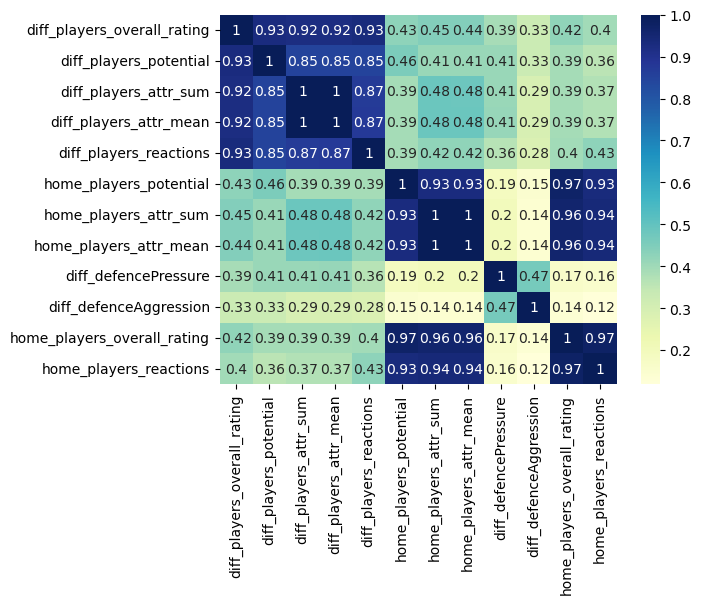

In [152]:
corr_2 = df.loc[:, top_factors_by_corr_list].corr()
corr_2

# plotting correlation heatmap 
corr_2_heatmap = sb.heatmap(corr_2, cmap="YlGnBu", annot=True) 
  
# displaying heatmap 
plt.show() 

In [153]:
# Абзац ниже надо переписать, т.к. в новом цикле исключил данные букмекерских контор

Видим, что есть признаки, которые очень сильно скоррелированы друг с другом. Стоит оставить только по одному из каждой группы скоррелированных признаков. Отберем из них тот, кто имеет более высокую корреляцию с целевым признаком.   


In [154]:
quantity_factors = ['diff_players_overall_rating', 
                    'diff_players_attr_sum', 
                    'diff_players_reactions', 
                    'home_players_attr_sum', 
                    'diff_defencePressure',  
                    'diff_defenceAggression', 
                    'home_players_overall_rating',  
#                     'diff_chanceCreationCrossing'
                   ]

### 3. Критерий V Крамера для категориальных переменных.

Рассчитаем критерий V Крамера для категориальных переменных и категориального целевого признака. Нам подходит этот критерий, так как все наши категориальные признаки не упорядочены. 

In [155]:
df_1 = df.copy(deep = True)

Для расчета V Крамера нам потребуется рассчитать Хи-квадрат, а для его расчета нам нужно будет закодировать все категориальные переменные числами.   
Но сначала надо заменить отсутствующие данные в категориальных переменных.

In [156]:
df_2 = df[cat_features].fillna('no_data')
df_2 = df[cat_features].apply(lambda x : pd.factorize(x)[0])+1


In [157]:
df_2

season  league_name  country_name  home_team_long_name  \
22653       1            1             1                    1   
22654       1            1             1                    2   
22655       1            1             1                    3   
22656       1            2             2                    4   
22657       1            1             1                    5   
...       ...          ...           ...                  ...   
25974       1            2             2                    0   
25975       1            2             2                    4   
25976       1            2             2                    9   
25977       1            2             2                    8   
25978       1            2             2                    6   

       home_buildUpPlaySpeedClass  home_buildUpPlayDribblingClass  \
22653                           1                               1   
22654                           2                               1   
22655                           1                               1   
22656                           1                               1   
22657                           2                               1   
...                           ...                             ...   
25974                           0                               0   
25975                           1                               1   
25976                           1                               1   
25977                           1                               1   
25978                           1                               1   

       home_buildUpPlayPassingClass  home_buildUpPlayPositioningClass  \
22653                             1                                 1   
22654                             1                                 1   
22655                             1                                 1   
22656                             1                                 2   
22657                             1                                 2   
...                             ...                               ...   
25974                             0                                 0   
25975                             1                                 2   
25976                             1                                 2   
25977                             1                                 2   
25978                             1                                 2   

       home_chanceCreationPassingClass  home_chanceCreationCrossingClass  \
22653                                1                                 1   
22654                                2                                 1   
22655                                1                                 2   
22656                                1                                 1   
22657                                1                                 1   
...                                ...                               ...   
25974                                0                                 0   
25975                                1                                 1   
25976                                1                                 1   
25977                                1                                 1   
25978                                1                                 1   

       home_chanceCreationShootingClass  home_chanceCreationPositioningClass  \
22653                                 1                                    1   
22654                                 2                                    2   
22655                                 3                                    2   
22656                                 1                                    1   
22657                                 1                                    1   
...                                 ...                                  ...   
25974                                 0        

In [158]:
len(df_2['match_result'].unique())

3

Для каждого фактора рассчитаем тест V Крамера по силе связи с целевым фактором (источники формулы и алгоритма расчета: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V , https://www.ibm.com/docs/ru/cognos-analytics/11.1.0?topic=terms-cramrs-v).

In [159]:
v_cramer_dict = {}

for i in df_2.columns:
    # для каждой пары "фактор - целевой признак" рассчитаем хи-квадрат
    X2 = chi2_contingency(df_2[['match_result', i]], correction=False)[0]
    
    # рассчитаем по формуле V Крамера для каждой пары
    v_cramer_i = np.sqrt( (X2/len(df)) / min(len(df_2['match_result'].unique()) -1, len(df_2[i].unique()) - 1))
    
    # сохраним результат
    v_cramer_dict[i] = v_cramer_i

v_cramer_df = pd.DataFrame(index = v_cramer_dict.keys(), data = {'v_cramer_with_target': v_cramer_dict.values()})

/var/folders/4m/k5zd839x4bx6gyq5lg_3gfmc0000gn/T/ipykernel_28846/3226525238.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  v_cramer_i = np.sqrt( (X2/len(df)) / min(len(df_2['match_result'].unique()) -1, len(df_2[i].unique()) - 1))


In [160]:
v_cramer_df.drop('match_result').sort_values(by = 'v_cramer_with_target', ascending = False)

v_cramer_with_target
season                                                inf
away_team_long_name                              1.562342
home_team_long_name                              1.491806
league_name                                      0.617249
country_name                                     0.617249
match_year                                       0.503101
away_chanceCreationPassingClass                  0.385535
home_chanceCreationPassingClass                  0.373100
away_chanceCreationCrossingClass                 0.366285
home_buildUpPlayDribblingClass                   0.363381
away_chanceCreationShootingClass                 0.362388
home_buildUpPlaySpeedClass                       0.357908
home_chanceCreationShootingClass                 0.354364
away_buildUpPlayDribblingClass                   0.353542
away_buildUpPlayPassingClass                     0.345883
home_buildUpPlayPositioningClass                 0.341854
away_buildUpPlaySpeedClass                       0.338517
away_chanceCreationPositioningClass              0.337166
home_chanceCreationCrossingClass                 0.327790
home_buildUpPlayPassingClass                     0.323064
away_defencePressureClass                        0.315685
home_defencePressureClass                        0.312431
away_buildUpPlayPositioningClass                 0.308024
home_chanceCreationPositioningClass              0.304389
away_defenceAggressionClass                      0.299542
home_defenceAggressionClass                      0.290011
away_defenceTeamWidthClass                       0.286918
away_defenceDefenderLineClass                    0.285473
home_defenceTeamWidthClass                       0.284861
home_defenceDefenderLineClass                    0.277558

Дата имеет крайне сомнительную ценность для прогноза несмотря на значения критерия, так что рассматривать его не будем. match_year и season по той же причине исключим. home_team_name, away_team_name имеют крайне высокий коэффициент (вообще, он больше 1, чего быть не должно; предположительно это вызвано размером таблицы и/или разницей в количестве категорий).   
Остальные показатели остаются в пределах 0.4-0.7, что тоже очень много. 

Впрочем, какие-то стоит убрать, чтобы перебор не был слишком долгим.

In [161]:
v_cramer_quartile_threshold = corr_quartile_threshold

In [162]:
top_factors_by_v_cramer_num = math.ceil(len(v_cramer_df) * v_cramer_quartile_threshold)

In [163]:
top_factors_by_v_cramer_num

7

In [164]:
top_factors_by_v_cramer_num

7

Запишем именные, а также не имеющие ценность для прогноза показатели в отдельную переменную.

In [165]:
name_features = ['match_result', 
                 'match_year', 
                 'season', 
                 'league_name', 
                 'country_name', 
                 'away_team_long_name', 
                 'home_team_long_name'
                ]

In [166]:
categorial_factors = list(v_cramer_df.drop(name_features).sort_values(
    by = 'v_cramer_with_target', ascending = False).head(top_factors_by_v_cramer_num).index) 

In [167]:
categorial_factors

['away_chanceCreationPassingClass',
 'home_chanceCreationPassingClass',
 'away_chanceCreationCrossingClass',
 'home_buildUpPlayDribblingClass',
 'away_chanceCreationShootingClass',
 'home_buildUpPlaySpeedClass',
 'home_chanceCreationShootingClass']

In [168]:
quantity_factors

['diff_players_overall_rating',
 'diff_players_attr_sum',
 'diff_players_reactions',
 'home_players_attr_sum',
 'diff_defencePressure',
 'diff_defenceAggression',
 'home_players_overall_rating']

## IV. Подготовка к моделированию

У нас есть набор количественных и категориальных фичей, которые мы будем перебирать с целью найти лучшую комбинацию факторов для прогнозирования с наибольшей точностью, которую будем замерять благодаря метрикам.   
В отобранных факторах остались пропуски, и если мы удалим их все - это будет слишком много строк. 

In [169]:
df_3 = df.loc[:, [target_num]+quantity_factors+categorial_factors]

In [170]:
df_3.isna().sum()

home_team_win                         0
diff_players_overall_rating           0
diff_players_attr_sum                 0
diff_players_reactions                0
home_players_attr_sum                 0
diff_defencePressure                132
diff_defenceAggression              132
home_players_overall_rating           0
away_chanceCreationPassingClass      67
home_chanceCreationPassingClass      67
away_chanceCreationCrossingClass     67
home_buildUpPlayDribblingClass       67
away_chanceCreationShootingClass     67
home_buildUpPlaySpeedClass           67
home_chanceCreationShootingClass     67
dtype: int64

In [171]:
len(df_3.dropna(how='any')) / len(df_3)

0.9603126879134095

In [172]:
len(df_3)

3326

Заменим пропуски в категориальных факторах на строчку 'нет данных'.

In [173]:
df_3.loc[:, categorial_factors] = df_3.loc[:, categorial_factors].fillna('no_data')

In [174]:
df_3.isna().sum()

home_team_win                         0
diff_players_overall_rating           0
diff_players_attr_sum                 0
diff_players_reactions                0
home_players_attr_sum                 0
diff_defencePressure                132
diff_defenceAggression              132
home_players_overall_rating           0
away_chanceCreationPassingClass       0
home_chanceCreationPassingClass       0
away_chanceCreationCrossingClass      0
home_buildUpPlayDribblingClass        0
away_chanceCreationShootingClass      0
home_buildUpPlaySpeedClass            0
home_chanceCreationShootingClass      0
dtype: int64

In [175]:
len(df_3.dropna(how='any')) / len(df_3)

0.9603126879134095

4% данных - это тоже существенно, но все же не столь критично. 

In [176]:
df_3.fillna(0, inplace=True)

In [177]:
df_3

home_team_win  diff_players_overall_rating  diff_players_attr_sum  \
22653              0                     3.000000              45.090909   
22654              0                     2.181818              33.000000   
22655              0                     3.290909              98.281818   
22656              0                    -2.454545             -18.454545   
22657              0                     0.454545             -49.727273   
...              ...                          ...                    ...   
25974              1                    -3.818182            -119.727273   
25975              0                    -1.909091             -53.727273   
25976              0                    -8.181818            -124.636364   
25977              0                     3.454545              37.818182   
25978              1                     5.909091              45.000000   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
22653                3.636364            1103.727273                  -8.0   
22654                4.636364            1100.272727                   9.0   
22655                6.136364            1153.181818                  -7.0   
22656               -1.545455            1152.727273                   3.0   
22657               -3.818182            1017.000000                  29.0   
...                       ...                    ...                   ...   
25974               -4.363636             941.090909                   0.0   
25975               -1.545455            1137.909091                   3.0   
25976               -9.727273            1036.454545                   3.0   
25977                3.090909            1132.727273                  11.0   
25978                1.909091            1083.000000                   5.0   

       diff_defenceAggression  home_players_overall_rating  \
22653                    24.0                    65.000000   
22654                     4.0                    65.454545   
22655                     4.0                    67.090909   
22656                     6.0                    64.727273   
22657                     3.0                    61.909091   
...                       ...                          ...   
25974                     0.0                    59.363636   
25975                     6.0                    65.727273   
25976                    11.0                    60.181818   
25977                    15.0                    68.000000   
25978                    10.0                    65.000000   

      away_chanceCreationPassingClass home_chanceCreationPassingClass  \
22653                          Normal                          Normal   
22654                          Normal                            Safe   
22655                          Normal                          Normal   
22656                          Normal                          Normal   
22657                          Normal                          Normal   
...                               ...                             ...   
25974                          Normal                         no_data   
25975                          Normal                          Normal   
25976                          Normal                          Normal   
25977                          Normal                          Normal   
25978                          Normal                          Normal   

      away_chanceCreationCrossingClass home_buildUpPlayDribblingClass  \
22653                           Normal                         Normal   
22654                           Little                         Normal   
22655                           Normal                         Normal   
22656                           Normal                         Normal   
22657                           Normal                         Normal   
...                                ...                            ...   
25974                   

In [178]:
df_3.isna().sum().sum()

0

### Разбиение на обучающую/валидирующую/тестовую выборки 

In [179]:
df_train, df_test = train_test_split(df_3, test_size = 0.3, stratify = df_3['home_team_win'], random_state=42)


### Кодирование категориальных фичей

In [180]:
# df_train_labeled = df_train.copy(deep = True)
# df_test_labeled = df_test.copy(deep = True)

ordinal_encoder = OrdinalEncoder()


df_train[categorial_factors] = ordinal_encoder.fit_transform(df_train[categorial_factors])
df_test[categorial_factors] = ordinal_encoder.transform(df_test[categorial_factors])
    
df_train.head()

home_team_win  diff_players_overall_rating  diff_players_attr_sum  \
25090              1                     0.545455              -2.090909   
25377              0                     4.818182             104.727273   
24668              1                    -4.909091             -48.363636   
25287              0                     1.636364               4.636364   
22951              1                     3.363636              35.000000   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
25090               -0.272727            1280.818182                   0.0   
25377                7.545455            1177.454545                   5.0   
24668               -4.090909            1219.909091                  11.0   
25287                5.818182            1042.636364                   1.0   
22951                2.636364            1031.545455                 -16.0   

       diff_defenceAggression  home_players_overall_rating  \
25090                     4.0                    76.545455   
25377                     3.0                    68.727273   
24668                     8.0                    71.181818   
25287                    -5.0                    64.727273   
22951                    -2.0                    63.909091   

       away_chanceCreationPassingClass  home_chanceCreationPassingClass  \
25090                              0.0                              0.0   
25377                              0.0                              0.0   
24668                              0.0                              0.0   
25287                              0.0                              0.0   
22951                              0.0                              0.0   

       away_chanceCreationCrossingClass  home_buildUpPlayDribblingClass  \
25090                               2.0                             2.0   
25377                               2.0                             2.0   
24668                               2.0                             2.0   
25287                               2.0                             2.0   
22951                               2.0                             2.0   

       away_chanceCreationShootingClass  home_buildUpPlaySpeedClass  \
25090                               2.0                         2.0   
25377                               2.0                         0.0   
24668                               2.0                         0.0   
25287                               2.0                         0.0   
22951                               2.0                         0.0   

       home_chanceCreationShootingClass  
25090                               2.0  
25377                               1.0  
24668                               2.0  
25287                               2.0  
22951                               2.0

### Нормализация данных

In [181]:
df_train.head(3)

home_team_win  diff_players_overall_rating  diff_players_attr_sum  \
25090              1                     0.545455              -2.090909   
25377              0                     4.818182             104.727273   
24668              1                    -4.909091             -48.363636   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
25090               -0.272727            1280.818182                   0.0   
25377                7.545455            1177.454545                   5.0   
24668               -4.090909            1219.909091                  11.0   

       diff_defenceAggression  home_players_overall_rating  \
25090                     4.0                    76.545455   
25377                     3.0                    68.727273   
24668                     8.0                    71.181818   

       away_chanceCreationPassingClass  home_chanceCreationPassingClass  \
25090                              0.0                              0.0   
25377                              0.0                              0.0   
24668                              0.0                              0.0   

       away_chanceCreationCrossingClass  home_buildUpPlayDribblingClass  \
25090                               2.0                             2.0   
25377                               2.0                             2.0   
24668                               2.0                             2.0   

       away_chanceCreationShootingClass  home_buildUpPlaySpeedClass  \
25090                               2.0                         2.0   
25377                               2.0                         0.0   
24668                               2.0                         0.0   

       home_chanceCreationShootingClass  
25090                               2.0  
25377                               1.0  
24668                               2.0

In [182]:
quantity_factors

['diff_players_overall_rating',
 'diff_players_attr_sum',
 'diff_players_reactions',
 'home_players_attr_sum',
 'diff_defencePressure',
 'diff_defenceAggression',
 'home_players_overall_rating']

In [183]:
len(quantity_factors)

7

In [184]:
stand_scaler = StandardScaler() # инициализируем экземпляр класса
    
stand_scaler.fit(df_train[quantity_factors]) # определяем параметры   
df_train[quantity_factors] = stand_scaler.transform(df_train[quantity_factors])
df_test[quantity_factors] = stand_scaler.transform(df_test[quantity_factors])

In [185]:
df_train.head(3)

home_team_win  diff_players_overall_rating  diff_players_attr_sum  \
25090              1                     0.111677              -0.048957   
25377              0                     1.042495               1.126727   
24668              1                    -1.076601              -0.558253   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
25090               -0.057345               0.909621              0.006205   
25377                1.377933              -0.175391              0.414271   
24668               -0.758295               0.270256              0.903951   

       diff_defenceAggression  home_players_overall_rating  \
25090                0.407025                     0.843268   
25377                0.311660                    -0.558452   
24668                0.788489                    -0.118377   

       away_chanceCreationPassingClass  home_chanceCreationPassingClass  \
25090                              0.0                              0.0   
25377                              0.0                              0.0   
24668                              0.0                              0.0   

       away_chanceCreationCrossingClass  home_buildUpPlayDribblingClass  \
25090                               2.0                             2.0   
25377                               2.0                             2.0   
24668                               2.0                             2.0   

       away_chanceCreationShootingClass  home_buildUpPlaySpeedClass  \
25090                               2.0                         2.0   
25377                               2.0                         0.0   
24668                               2.0                         0.0   

       home_chanceCreationShootingClass  
25090                               2.0  
25377                               1.0  
24668                               2.0

In [186]:
df_train.loc[:, quantity_factors].describe()

diff_players_overall_rating  diff_players_attr_sum  \
count                 2.328000e+03           2.328000e+03   
mean                  1.526080e-17          -3.052160e-17   
std                   1.000215e+00           1.000215e+00   
min                  -3.096674e+00          -3.253821e+00   
25%                  -6.408990e-01          -6.355481e-01   
50%                   1.265407e-02           1.157822e-02   
75%                   6.464025e-01           6.534515e-01   
max                   3.280419e+00           3.218943e+00   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
count            2.328000e+03           2.328000e+03          2.328000e+03   
mean            -9.156479e-18           1.143034e-15          1.526080e-18   
std              1.000215e+00           1.000215e+00          1.000215e+00   
min             -2.811076e+00          -2.758238e+00         -2.850259e+00   
25%             -6.748486e-01          -6.730469e-01         -6.467009e-01   
50%              2.610120e-02           1.880389e-02          6.205132e-03   
75%              6.769831e-01           7.054062e-01          6.591112e-01   
max              3.096929e+00           2.941277e+00          3.270736e+00   

       diff_defenceAggression  home_players_overall_rating  
count            2.328000e+03                 2.328000e+03  
mean             6.104319e-18                -1.938121e-16  
std              1.000215e+00                 1.000215e+00  
min             -3.026146e+00                -2.383947e+00  
25%             -6.419990e-01                -6.888440e-01  
50%              2.556198e-02                 9.351097e-02  
75%              6.931230e-01                 6.802772e-01  
max              2.981904e+00                 2.636165e+00

## V. Моделирование. Перебор факторов

In [187]:
potential_predictors = list(df_3.drop(target_num, axis = 1).columns)
potential_predictors

['diff_players_overall_rating',
 'diff_players_attr_sum',
 'diff_players_reactions',
 'home_players_attr_sum',
 'diff_defencePressure',
 'diff_defenceAggression',
 'home_players_overall_rating',
 'away_chanceCreationPassingClass',
 'home_chanceCreationPassingClass',
 'away_chanceCreationCrossingClass',
 'home_buildUpPlayDribblingClass',
 'away_chanceCreationShootingClass',
 'home_buildUpPlaySpeedClass',
 'home_chanceCreationShootingClass']

Теперь можно перебрать комбинации для 2, 3, 4 регрессоров (больше не имеет смысла, так как нам нужно отобрать именно 2-3 самых важных фактора. 4 - уже прозапас).
Впрочем, количество предикторов можно и менять по желанию. 

In [188]:
numbers_of_predictors = [2,3,4,5]

In [189]:
predictors_number_combs_dict = {}

for i in numbers_of_predictors:
    combs_with_i_predictors = it.combinations(potential_predictors, i) 
    ### так как it.combinations выплевывает чисто генератор или как там это называется, его приходится отельно сохранять в список или что-то вроде.
    ### получается список списков-комбинаций.
    list_of_combs_with_i_predictors = [list(i) for i in combs_with_i_predictors]
    ### А у нас будет словарь списков списков
    predictors_number_combs_dict[i] = list_of_combs_with_i_predictors

In [190]:
predictors_number_combs_dict

{2: [['diff_players_overall_rating', 'diff_players_attr_sum'],
  ['diff_players_overall_rating', 'diff_players_reactions'],
  ['diff_players_overall_rating', 'home_players_attr_sum'],
  ['diff_players_overall_rating', 'diff_defencePressure'],
  ['diff_players_overall_rating', 'diff_defenceAggression'],
  ['diff_players_overall_rating', 'home_players_overall_rating'],
  ['diff_players_overall_rating', 'away_chanceCreationPassingClass'],
  ['diff_players_overall_rating', 'home_chanceCreationPassingClass'],
  ['diff_players_overall_rating', 'away_chanceCreationCrossingClass'],
  ['diff_players_overall_rating', 'home_buildUpPlayDribblingClass'],
  ['diff_players_overall_rating', 'away_chanceCreationShootingClass'],
  ['diff_players_overall_rating', 'home_buildUpPlaySpeedClass'],
  ['diff_players_overall_rating', 'home_chanceCreationShootingClass'],
  ['diff_players_attr_sum', 'diff_players_reactions'],
  ['diff_players_attr_sum', 'home_players_attr_sum'],
  ['diff_players_attr_sum', 'diff_

In [191]:
for i in predictors_number_combs_dict:
    print(len(predictors_number_combs_dict[i]))

91
364
1001
2002


### Цикл перебора моделей по target_num

In [192]:
target_num, df_3['home_team_win'].unique()

('home_team_win', array([0, 1]))

In [193]:
%%time
log_reg_results_dict = {}

col_comb_number = []
col_comb = []
col_model = []
col_acc = []
col_recall = []
col_prec = []
col_f1 = []


for i in predictors_number_combs_dict:
    print(f'комбинации из {i} предикторов')
    print()
    for j in predictors_number_combs_dict[i]:
        print()
        print(f'комбинация {j} (количество предикторов {i})')
        print()
        
        log_reg_j = LogisticRegression()
        log_reg_j.fit(df_train.loc[:,j], df_train[target_num])
        print(f'модель регрессии обучена')
        target_predicted_j = log_reg_j.predict(df_test.loc[:,j])
        print(f'модель регрессии дала предсказание')
        accuracy_j = accuracy_score(df_test[target_num], target_predicted_j)
        print(f'accuracy комбинации {j} в регрессии: {accuracy_j}')
        recall_j = recall_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'recall комбинации {j} в регрессии: {recall_j}')
        precision_j = precision_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'precision комбинации {j} в регрессии: {precision_j}')
        f1_j = f1_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'f1 комбинации {j}: {f1_j}')
        
        col_comb_number.append(i)
        col_comb.append(str(j))
        col_model.append('Log_reg')
        col_acc.append(accuracy_j)
        col_recall.append(recall_j)
        col_prec.append(precision_j)
        col_f1.append(f1_j)
        
        tree_j = DecisionTreeClassifier(random_state=42)
        tree_j.fit(df_train.loc[:,j], df_train[target_num])
        print()
        print(f'дерево обучено')
        target_predicted_j = tree_j.predict(df_test.loc[:,j])
        print(f'дерево дало предсказание')
        accuracy_j = accuracy_score(df_test[target_num], target_predicted_j)
        print(f'accuracy комбинации {j} в дереве: {accuracy_j}')
        recall_j = recall_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'recall комбинации {j} в дереве: {recall_j}')
        precision_j = precision_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'precision комбинации {j} в дереве: {precision_j}')
        f1_j = f1_score(df_test[target_num], target_predicted_j, average = 'weighted')
        print(f'f1 комбинации {j}: {f1_j} в дереве')
        
        col_comb_number.append(i)
        col_comb.append(str(j))
        col_model.append('decision_tree')
        col_acc.append(accuracy_j)
        col_recall.append(recall_j)
        col_prec.append(precision_j)
        col_f1.append(f1_j)
        
               


комбинации из 2 предикторов


комбинация ['diff_players_overall_rating', 'diff_players_attr_sum'] (количество предикторов 2)

модель регрессии обучена
модель регрессии дала предсказание
accuracy комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в регрессии: 0.6362725450901804
recall комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в регрессии: 0.6362725450901804
precision комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в регрессии: 0.6324718924840259
f1 комбинации ['diff_players_overall_rating', 'diff_players_attr_sum']: 0.6312767668459315

дерево обучено
дерево дало предсказание
accuracy комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в дереве: 0.5340681362725451
recall комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в дереве: 0.5340681362725451
precision комбинации ['diff_players_overall_rating', 'diff_players_attr_sum'] в дереве: 0.5379962356456105
f1 комбинации ['diff_players_overall_ra

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics

модель регрессии обучена
модель регрессии дала предсказание
accuracy комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в регрессии: 0.56312625250501
recall комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в регрессии: 0.56312625250501
precision комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в регрессии: 0.559881668098101
f1 комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass']: 0.4215080879462273

дерево обучено
дерево дало предсказание
accuracy комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в дереве: 0.5591182364729459
recall комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в дереве: 0.5591182364729459
precision комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationShootingClass'] в дереве: 0.5162794788756158
f1 комбинации ['home_chanceCreationPassingClass', 'away_chanceCre

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



дерево обучено
дерево дало предсказание
accuracy комбинации ['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass'] в дереве: 0.5551102204408818
recall комбинации ['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass'] в дереве: 0.5551102204408818
precision комбинации ['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass'] в дереве: 0.5194730711823049
f1 комбинации ['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass']: 0.4564730461548488 в дереве

комбинация ['home_buildUpPlayDribblingClass', 'home_chanceCreationShootingClass'] (количество предикторов 2)

модель регрессии обучена
модель регрессии дала предсказание
accuracy комбинации ['home_buildUpPlayDribblingClass', 'home_chanceCreationShootingClass'] в регрессии: 0.5591182364729459
recall комбинации ['home_buildUpPlayDribblingClass', 'home_chanceCreationShootingClass'] в регрессии: 0.5591182364729459
precision комбинации ['home_buildUpPlayDribblingClass', 'home_chanceCreationShootingClass'] в р

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


модель регрессии обучена
модель регрессии дала предсказание
accuracy комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass'] в регрессии: 0.5581162324649298
recall комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass'] в регрессии: 0.5581162324649298
precision комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass'] в регрессии: 0.4832554605501515
f1 комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass']: 0.4106884684056076

дерево обучено
дерево дало предсказание
accuracy комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass'] в дереве: 0.5450901803607214
recall комбинации ['home_chanceCreationPassingClass', 'away_chanceCreationCrossingClass', 'home_buildUpPlaySpeedClass'] в дереве: 0.5450901803607214
pr

/Users/admin/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 комбинации ['away_chanceCreationShootingClass', 'home_buildUpPlaySpeedClass', 'home_chanceCreationShootingClass']: 0.5015318667678139

дерево обучено
дерево дало предсказание
accuracy комбинации ['away_chanceCreationShootingClass', 'home_buildUpPlaySpeedClass', 'home_chanceCreationShootingClass'] в дереве: 0.5681362725450901
recall комбинации ['away_chanceCreationShootingClass', 'home_buildUpPlaySpeedClass', 'home_chanceCreationShootingClass'] в дереве: 0.5681362725450901
precision комбинации ['away_chanceCreationShootingClass', 'home_buildUpPlaySpeedClass', 'home_chanceCreationShootingClass'] в дереве: 0.5529184072131648
f1 комбинации ['away_chanceCreationShootingClass', 'home_buildUpPlaySpeedClass', 'home_chanceCreationShootingClass']: 0.523052851202018 в дереве
комбинации из 4 предикторов


комбинация ['diff_players_overall_rating', 'diff_players_attr_sum', 'diff_players_reactions', 'home_players_attr_sum'] (количество предикторов 4)

модель регрессии обучена
модель регрессии дал

In [194]:
print(f'col_comb_number {len(col_comb_number)}')
print(f'col_comb  {len(col_comb)}')
print(f'col_model  {len(col_model)}')
print(f'col_acc  {len(col_acc)}')
print(f'col_recall  {len(col_recall)}')
print(f'col_prec  {len(col_prec)}')
print(f'col_f1  {len(col_f1)}')

col_comb_number 6916
col_comb  6916
col_model  6916
col_acc  6916
col_recall  6916
col_prec  6916
col_f1  6916


In [195]:
df_results = pd.DataFrame(data = {'comb_number': col_comb_number, 
                                  'combination': col_comb,
                                  'model': col_model,
                                  'accuracy': col_acc, 
                                  'recall': col_recall, 
                                  'precision': col_prec, 
                                  'f1_score': col_f1
                                 }
                         )        

In [196]:
df_results

comb_number                                        combination  \
0               2  ['diff_players_overall_rating', 'diff_players_...   
1               2  ['diff_players_overall_rating', 'diff_players_...   
2               2  ['diff_players_overall_rating', 'diff_players_...   
3               2  ['diff_players_overall_rating', 'diff_players_...   
4               2  ['diff_players_overall_rating', 'home_players_...   
...           ...                                                ...   
6911            5  ['home_chanceCreationPassingClass', 'away_chan...   
6912            5  ['home_chanceCreationPassingClass', 'home_buil...   
6913            5  ['home_chanceCreationPassingClass', 'home_buil...   
6914            5  ['away_chanceCreationCrossingClass', 'home_bui...   
6915            5  ['away_chanceCreationCrossingClass', 'home_bui...   

              model  accuracy    recall  precision  f1_score  
0           Log_reg  0.636273  0.636273   0.632472  0.631277  
1     decision_tree  0.534068  0.534068   0.537996  0.535453  
2           Log_reg  0.636273  0.636273   0.632379  0.630658  
3     decision_tree  0.545090  0.545090   0.544640  0.544856  
4           Log_reg  0.638277  0.638277   0.634427  0.631825  
...             ...       ...       ...        ...       ...  
6911  decision_tree  0.550100  0.550100   0.525258  0.500199  
6912        Log_reg  0.564128  0.564128   0.545460  0.492484  
6913  decision_tree  0.563126  0.563126   0.544458  0.507440  
6914        Log_reg  0.558116  0.558116   0.533648  0.487389  
6915  decision_tree  0.566132  0.566132   0.549385  0.508828  

[6916 rows x 7 columns]

In [197]:
df_results.to_excel('df_results_excel.xlsx')

In [198]:
df_results.sort_values(by = 'accuracy', ascending = False)

comb_number                                        combination  \
3800            5  ['diff_players_overall_rating', 'home_players_...   
4122            5  ['diff_players_overall_rating', 'diff_defenceA...   
1320            4  ['diff_players_overall_rating', 'diff_defenceA...   
4530            5  ['diff_players_attr_sum', 'diff_players_reacti...   
4436            5  ['diff_players_attr_sum', 'diff_players_reacti...   
...           ...                                                ...   
6059            5  ['home_players_attr_sum', 'diff_defencePressur...   
6281            5  ['home_players_attr_sum', 'home_players_overal...   
6433            5  ['diff_defencePressure', 'diff_defenceAggressi...   
2493            4  ['diff_defencePressure', 'diff_defenceAggressi...   
6279            5  ['home_players_attr_sum', 'home_players_overal...   

              model  accuracy    recall  precision  f1_score  
3800        Log_reg  0.664329  0.664329   0.661649  0.659341  
4122        Log_reg  0.663327  0.663327   0.660645  0.658032  
1320        Log_reg  0.661323  0.661323   0.658580  0.655796  
4530        Log_reg  0.661323  0.661323   0.659027  0.654079  
4436        Log_reg  0.661323  0.661323   0.658950  0.654305  
...             ...       ...       ...        ...       ...  
6059  decision_tree  0.497996  0.497996   0.497871  0.497933  
6281  decision_tree  0.494990  0.494990   0.495241  0.495113  
6433  decision_tree  0.490982  0.490982   0.492984  0.491859  
2493  decision_tree  0.490982  0.490982   0.495435  0.492576  
6279  decision_tree  0.488978  0.488978   0.487696  0.488289  

[6916 rows x 7 columns]

In [199]:
df_results.sort_values(by = 'f1_score', ascending = False)

comb_number                                        combination    model  \
3800            5  ['diff_players_overall_rating', 'home_players_...  Log_reg   
4122            5  ['diff_players_overall_rating', 'diff_defenceA...  Log_reg   
1320            4  ['diff_players_overall_rating', 'diff_defenceA...  Log_reg   
1322            4  ['diff_players_overall_rating', 'diff_defenceA...  Log_reg   
3762            5  ['diff_players_overall_rating', 'home_players_...  Log_reg   
...           ...                                                ...      ...   
166             2  ['away_chanceCreationCrossingClass', 'home_bui...  Log_reg   
152             2  ['home_chanceCreationPassingClass', 'away_chan...  Log_reg   
892             3  ['away_chanceCreationCrossingClass', 'home_bui...  Log_reg   
870             3  ['home_chanceCreationPassingClass', 'away_chan...  Log_reg   
162             2  ['away_chanceCreationCrossingClass', 'home_bui...  Log_reg   

      accuracy    recall  precision  f1_score  
3800  0.664329  0.664329   0.661649  0.659341  
4122  0.663327  0.663327   0.660645  0.658032  
1320  0.661323  0.661323   0.658580  0.655796  
1322  0.660321  0.660321   0.657491  0.655077  
3762  0.659319  0.659319   0.656411  0.654545  
...        ...       ...        ...       ...  
166   0.561122  0.561122   0.314858  0.403374  
152   0.561122  0.561122   0.314858  0.403374  
892   0.561122  0.561122   0.314858  0.403374  
870   0.561122  0.561122   0.314858  0.403374  
162   0.561122  0.561122   0.314858  0.403374  

[6916 rows x 7 columns]

In [200]:
df_results_sorted = df_results.sort_values(by = 'f1_score', ascending = False).reset_index(drop=True)

In [201]:
best_combination = df_results_sorted['combination'][0]

In [202]:
best_combination

"['diff_players_overall_rating', 'home_players_attr_sum', 'diff_defenceAggression', 'home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass']"

In [203]:
best_combination.replace('[', '').replace(']', '').split(',')

["'diff_players_overall_rating'",
 " 'home_players_attr_sum'",
 " 'diff_defenceAggression'",
 " 'home_buildUpPlayDribblingClass'",
 " 'home_buildUpPlaySpeedClass'"]

In [204]:
best_combination = ['diff_players_overall_rating', 
                    'home_players_attr_sum', 
                    'diff_defenceAggression', 
                    'home_buildUpPlayDribblingClass', 
                    'home_buildUpPlaySpeedClass']

### Обучим нашу регрессию еще раз на комбинации лучших фичей, т.к. до этого был цикл перебора моделей, и скорее всего наша регрессия обучена на последней комбинации.

In [205]:
best_model = LogisticRegression()
best_model.fit(df_train.loc[:,best_combination], df_train[target_num])


LogisticRegression()

In [206]:
target_predicted = best_model.predict(df_test.loc[:,best_combination])

In [207]:
print('Accuracy: %.2f' % accuracy_score(df_test[target_num], target_predicted))
print('Recall: %.2f' % recall_score(df_test[target_num], target_predicted, average = 'weighted'))
print('Precision: %.2f' % precision_score(df_test[target_num], target_predicted, average = 'weighted'))
print('f1_score: %.2f' % f1_score(df_test[target_num], target_predicted, average = 'weighted'))

Accuracy: 0.66
Recall: 0.66
Precision: 0.66
f1_score: 0.66


Успех! Регрессия обучилась на лучших фичах и показала аналогичные точность и качество, как было в цикле.
Теперь наша модель готова делать предсказание на реальных данных.

## VI. Создадим датафрейм c комбинациями из всех возможных пар команд (с учетом их позиционирования).

Определим количество уникальных команд

In [208]:
teams_list = list(df['home_team_long_name'].dropna().unique()) + list(df['away_team_long_name'].dropna().unique())
teams_set = set(teams_list)
unique_teams = list(teams_set)

In [209]:
len(unique_teams)

184

In [210]:
unique_home_teams = ['home_' + sub for sub in unique_teams]
unique_away_teams = ['away_' + sub for sub in unique_teams]

In [211]:
len(unique_home_teams), len(unique_away_teams)

(184, 184)

In [212]:
all_teams = unique_home_teams + unique_away_teams

In [213]:
len(all_teams)

368

Переберем все возможные комбинации столкновений команд

In [214]:
all_team_combs_dict = {}

combs_with_2_teams = it.combinations(all_teams, 2) 
### получается список списков-комбинаций.
list_of_combs_with_2_teams = [list(i) for i in combs_with_2_teams]
### А у нас будет словарь списков списков
all_team_combs_dict = list_of_combs_with_2_teams
    

In [215]:
all_team_combs_dict

[['home_Olympique de Marseille', 'home_SV Zulte-Waregem'],
 ['home_Olympique de Marseille', 'home_SV Werder Bremen'],
 ['home_Olympique de Marseille', 'home_VfB Stuttgart'],
 ['home_Olympique de Marseille', 'home_Atlético Madrid'],
 ['home_Olympique de Marseille', 'home_Ajax'],
 ['home_Olympique de Marseille', 'home_Empoli'],
 ['home_Olympique de Marseille', 'home_FC Barcelona'],
 ['home_Olympique de Marseille', 'home_Aston Villa'],
 ['home_Olympique de Marseille', 'home_SL Benfica'],
 ['home_Olympique de Marseille', 'home_KRC Genk'],
 ['home_Olympique de Marseille', 'home_Sampdoria'],
 ['home_Olympique de Marseille', 'home_FC Thun'],
 ['home_Olympique de Marseille', 'home_Wisła Kraków'],
 ['home_Olympique de Marseille', 'home_Oud-Heverlee Leuven'],
 ['home_Olympique de Marseille', 'home_Sassuolo'],
 ['home_Olympique de Marseille', 'home_KVC Westerlo'],
 ['home_Olympique de Marseille', 'home_FC Ingolstadt 04'],
 ['home_Olympique de Marseille', 'home_SC Cambuur'],
 ['home_Olympique de M

In [216]:
len(all_team_combs_dict)

67528

In [217]:
# Датафрейм со всеми комбинациями игр двух команд

df_all_team = pd.DataFrame(all_team_combs_dict)
df_all_team

0                      1
0      home_Olympique de Marseille  home_SV Zulte-Waregem
1      home_Olympique de Marseille  home_SV Werder Bremen
2      home_Olympique de Marseille     home_VfB Stuttgart
3      home_Olympique de Marseille   home_Atlético Madrid
4      home_Olympique de Marseille              home_Ajax
...                            ...                    ...
67523                away_Atalanta          away_Juventus
67524                away_Atalanta       away_Southampton
67525              away_Stoke City          away_Juventus
67526              away_Stoke City       away_Southampton
67527                away_Juventus       away_Southampton

[67528 rows x 2 columns]

In [218]:
df_all_team[['position_1', 'team_1']] = df_all_team[0].str.split('_', expand=True)
df_all_team[['position_2', 'team_2']] = df_all_team[1].str.split('_', expand=True)

In [219]:
df_all_team

0                      1 position_1  \
0      home_Olympique de Marseille  home_SV Zulte-Waregem       home   
1      home_Olympique de Marseille  home_SV Werder Bremen       home   
2      home_Olympique de Marseille     home_VfB Stuttgart       home   
3      home_Olympique de Marseille   home_Atlético Madrid       home   
4      home_Olympique de Marseille              home_Ajax       home   
...                            ...                    ...        ...   
67523                away_Atalanta          away_Juventus       away   
67524                away_Atalanta       away_Southampton       away   
67525              away_Stoke City          away_Juventus       away   
67526              away_Stoke City       away_Southampton       away   
67527                away_Juventus       away_Southampton       away   

                       team_1 position_2            team_2  
0      Olympique de Marseille       home  SV Zulte-Waregem  
1      Olympique de Marseille       home  SV Werder Bremen  
2      Olympique de Marseille       home     VfB Stuttgart  
3      Olympique de Marseille       home   Atlético Madrid  
4      Olympique de Marseille       home              Ajax  
...                       ...        ...               ...  
67523                Atalanta       away          Juventus  
67524                Atalanta       away       Southampton  
67525              Stoke City       away          Juventus  
67526              Stoke City       away       Southampton  
67527                Juventus       away       Southampton  

[67528 rows x 6 columns]

In [220]:
df_all_team.drop([0, 1], axis=1, inplace=True)

In [221]:
df_all_team

position_1                  team_1 position_2            team_2
0           home  Olympique de Marseille       home  SV Zulte-Waregem
1           home  Olympique de Marseille       home  SV Werder Bremen
2           home  Olympique de Marseille       home     VfB Stuttgart
3           home  Olympique de Marseille       home   Atlético Madrid
4           home  Olympique de Marseille       home              Ajax
...          ...                     ...        ...               ...
67523       away                Atalanta       away          Juventus
67524       away                Atalanta       away       Southampton
67525       away              Stoke City       away          Juventus
67526       away              Stoke City       away       Southampton
67527       away                Juventus       away       Southampton

[67528 rows x 4 columns]

Видим, что у нас есть сочетания away-away и home-home и скорее всего зеркальные сочетания команд.

Удалим их, сделав так, чтобы в position_1 были только команды, играющие дома, а в position_2 - команды, играющие в гостях.

In [222]:
df_all_team.drop(df_all_team[(df_all_team['position_1'] == 'away') \
                             & (df_all_team['position_2'] == 'away')].index, inplace=True)

df_all_team.drop(df_all_team[(df_all_team['position_1'] == 'home') \
                             & (df_all_team['position_2'] == 'home')].index, inplace=True)


In [223]:
df_all_team

position_1                  team_1 position_2                  team_2
183         home  Olympique de Marseille       away  Olympique de Marseille
184         home  Olympique de Marseille       away        SV Zulte-Waregem
185         home  Olympique de Marseille       away        SV Werder Bremen
186         home  Olympique de Marseille       away           VfB Stuttgart
187         home  Olympique de Marseille       away         Atlético Madrid
...          ...                     ...        ...                     ...
50687       home             Southampton       away          BSC Young Boys
50688       home             Southampton       away                Atalanta
50689       home             Southampton       away              Stoke City
50690       home             Southampton       away                Juventus
50691       home             Southampton       away             Southampton

[33856 rows x 4 columns]

Получили очищенный датафрейм со всеми комбинациями игр двух команд

In [224]:
df_all_team['position_1'].unique(), df_all_team['position_2'].unique()

(array(['home'], dtype=object), array(['away'], dtype=object))

### Теперь создадим два датафрейма с со средним значением лучших фичей по home и away командам.

Посмотрим наши фичи

In [225]:
best_combination

['diff_players_overall_rating',
 'home_players_attr_sum',
 'diff_defenceAggression',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlaySpeedClass']

Значения diff_players_overall_rating и diff_defenceAggression мы брать не будем, а рассчитаем их самостоятельно в итоговом датасете. В текущие же возьмем аналогичные атрибуты для команд home и away.

#### Соберем средние значения для команд, играющих дома

In [226]:
df_home_num_factors = df.loc[:, ['home_team_long_name', 
                                 'home_players_overall_rating', 
                                 'home_players_attr_sum', 
                                 'home_defenceAggression']]

In [227]:
df_home_class_factors = df.loc[:, ['home_team_long_name', 
                                   'home_buildUpPlayDribblingClass', 
                                   'home_buildUpPlaySpeedClass']]

In [228]:
agg_home_num = df_home_num_factors.groupby('home_team_long_name')[['home_players_overall_rating', 
                                                    'home_players_attr_sum', 
                                                    'home_defenceAggression']].agg('mean')

agg_home_num.reset_index(inplace=True)

In [229]:
agg_home_class = df_home_class_factors.groupby('home_team_long_name')\
[['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass']].agg(pd.Series.mode)

agg_home_class.reset_index(inplace=True)

In [230]:
agg_home_num

home_team_long_name  home_players_overall_rating  \
0                      1. FC Köln                    75.197861   
1                 1. FSV Mainz 05                    74.481283   
2                    ADO Den Haag                    69.486631   
3                       AS Monaco                    77.043062   
4                AS Saint-Étienne                    75.541148   
5                              AZ                    70.679144   
6                        Aberdeen                    67.550239   
7            Académica de Coimbra                    68.786096   
8                            Ajax                    76.144385   
9                      Angers SCO                    69.799043   
10                        Arsenal                    81.258373   
11                    Aston Villa                    74.818182   
12                       Atalanta                    73.703349   
13        Athletic Club de Bilbao                    78.665072   
14                Atlético Madrid                    80.545455   
15                 BSC Young Boys                    68.671717   
16            Bayer 04 Leverkusen                    78.010695   
17                    Boavista FC                    68.491979   
18                        Bologna                    72.894737   
19              Borussia Dortmund                    80.668449   
20       Borussia Mönchengladbach                    76.374332   
21                    Bournemouth                    72.172249   
22                    CD Nacional                    69.465241   
23               CF Os Belenenses                    71.310160   
24                    CS Marítimo                    68.812834   
25                          Carpi                    70.918660   
26                         Celtic                    70.808612   
27                        Chelsea                    82.559809   
28                  Chievo Verona                    73.923445   
29                 Club Brugge KV                    72.654545   
30                       Cracovia                    64.272727   
31                 Crystal Palace                    75.732057   
32                  De Graafschap                    65.626738   
33                      Dundee FC                    61.682828   
34                  Dundee United                    63.346890   
35                   ES Troyes AC                    68.234450   
36            Eintracht Frankfurt                    74.491979   
37                         Empoli                    72.162679   
38           En Avant de Guingamp                    72.306220   
39                  Estoril Praia                    71.224599   
40                        Everton                    77.671770   
41                      Excelsior                    66.850267   
42                      FC Arouca                    69.462567   
43                    FC Augsburg                    74.427807   
44                   FC Barcelona                    85.014354   
45                       FC Basel                    72.146465   
46               FC Bayern Munich                    84.122995   
47                   FC Groningen                    70.796791   
48               FC Ingolstadt 04                    71.310160   
49                     FC Lorient                    72.110048   
50                      FC Luzern                    64.606061   
51                      FC Nantes                    72.386603   
52           FC Paços de Ferreira                    69.940107   
53                       FC Porto                    78.245989   
54                  FC Schalke 04                    77.663102   
55                        FC Sion                    67.686869   
56                  FC St. Gallen                    63.378788   
57                        FC Thun                    61.353535   
58                      FC Twente                    68.534759   
59                     FC Utrecht                    6

In [231]:
agg_home_class

home_team_long_name home_buildUpPlayDribblingClass  \
0                      1. FC Köln                         Normal   
1                 1. FSV Mainz 05                         Normal   
2                    ADO Den Haag                         Normal   
3                       AS Monaco                         Normal   
4                AS Saint-Étienne                         Normal   
5                              AZ                         Normal   
6                        Aberdeen                         Normal   
7            Académica de Coimbra                         Normal   
8                            Ajax                         Normal   
9                      Angers SCO                         Normal   
10                        Arsenal                         Normal   
11                    Aston Villa                         Normal   
12                       Atalanta                         Normal   
13        Athletic Club de Bilbao                         Normal   
14                Atlético Madrid                         Normal   
15                 BSC Young Boys                         Normal   
16            Bayer 04 Leverkusen                         Little   
17                    Boavista FC                         Normal   
18                        Bologna                         Normal   
19              Borussia Dortmund                         Normal   
20       Borussia Mönchengladbach                         Normal   
21                    Bournemouth                         Normal   
22                    CD Nacional                         Normal   
23               CF Os Belenenses                         Normal   
24                    CS Marítimo                         Normal   
25                          Carpi                         Normal   
26                         Celtic                         Normal   
27                        Chelsea                         Normal   
28                  Chievo Verona                         Normal   
29                 Club Brugge KV                         Normal   
30                       Cracovia                         Normal   
31                 Crystal Palace                         Normal   
32                  De Graafschap                         Little   
33                      Dundee FC                         Normal   
34                  Dundee United                         Normal   
35                   ES Troyes AC                         Normal   
36            Eintracht Frankfurt                         Normal   
37                         Empoli                         Normal   
38           En Avant de Guingamp                         Normal   
39                  Estoril Praia                         Normal   
40                        Everton                         Normal   
41                      Excelsior                         Normal   
42                      FC Arouca                         Normal   
43                    FC Augsburg                         Normal   
44                   FC Barcelona                         Normal   
45                       FC Basel                         Normal   
46               FC Bayern Munich                         Little   
47                   FC Groningen                         Little   
48               FC Ingolstadt 04                         Normal   
49                     FC Lorient                         Normal   
50                      FC Luzern                         Normal   
51                      FC Nantes                           Lots   
52           FC Paços de Ferreira                         Normal   
53                       FC Porto                         Normal   
54                  FC Schalke 04                         Normal   
55                        FC Sion                         Normal   
56                  FC St. Gallen                         Normal   
57                        FC Thun                         Normal   
58

Теперь объединяем agg_home_num и agg_home_class

In [232]:
agg_home = pd.merge(agg_home_num, agg_home_class, how='left', on='home_team_long_name')

In [233]:
agg_home

home_team_long_name  home_players_overall_rating  \
0                      1. FC Köln                    75.197861   
1                 1. FSV Mainz 05                    74.481283   
2                    ADO Den Haag                    69.486631   
3                       AS Monaco                    77.043062   
4                AS Saint-Étienne                    75.541148   
5                              AZ                    70.679144   
6                        Aberdeen                    67.550239   
7            Académica de Coimbra                    68.786096   
8                            Ajax                    76.144385   
9                      Angers SCO                    69.799043   
10                        Arsenal                    81.258373   
11                    Aston Villa                    74.818182   
12                       Atalanta                    73.703349   
13        Athletic Club de Bilbao                    78.665072   
14                Atlético Madrid                    80.545455   
15                 BSC Young Boys                    68.671717   
16            Bayer 04 Leverkusen                    78.010695   
17                    Boavista FC                    68.491979   
18                        Bologna                    72.894737   
19              Borussia Dortmund                    80.668449   
20       Borussia Mönchengladbach                    76.374332   
21                    Bournemouth                    72.172249   
22                    CD Nacional                    69.465241   
23               CF Os Belenenses                    71.310160   
24                    CS Marítimo                    68.812834   
25                          Carpi                    70.918660   
26                         Celtic                    70.808612   
27                        Chelsea                    82.559809   
28                  Chievo Verona                    73.923445   
29                 Club Brugge KV                    72.654545   
30                       Cracovia                    64.272727   
31                 Crystal Palace                    75.732057   
32                  De Graafschap                    65.626738   
33                      Dundee FC                    61.682828   
34                  Dundee United                    63.346890   
35                   ES Troyes AC                    68.234450   
36            Eintracht Frankfurt                    74.491979   
37                         Empoli                    72.162679   
38           En Avant de Guingamp                    72.306220   
39                  Estoril Praia                    71.224599   
40                        Everton                    77.671770   
41                      Excelsior                    66.850267   
42                      FC Arouca                    69.462567   
43                    FC Augsburg                    74.427807   
44                   FC Barcelona                    85.014354   
45                       FC Basel                    72.146465   
46               FC Bayern Munich                    84.122995   
47                   FC Groningen                    70.796791   
48               FC Ingolstadt 04                    71.310160   
49                     FC Lorient                    72.110048   
50                      FC Luzern                    64.606061   
51                      FC Nantes                    72.386603   
52           FC Paços de Ferreira                    69.940107   
53                       FC Porto                    78.245989   
54                  FC Schalke 04                    77.663102   
55                        FC Sion                    67.686869   
56                  FC St. Gallen                    63.378788   
57                        FC Thun                    61.353535   
58                      FC Twente                    68.534759   
59                     FC Utrecht                    6

#### Теперь соберем средние значения (и моды по категориальным переменным) по командам, играющим в гостях

In [234]:
df_away_num_factors = df.loc[:, ['away_team_long_name', 
                                 'away_players_overall_rating', 
                                 'away_players_attr_sum', 
                                 'away_defenceAggression']]

In [235]:
df_away_class_factors = df.loc[:, ['away_team_long_name', 
                                   'away_buildUpPlayDribblingClass', 
                                   'away_buildUpPlaySpeedClass']]

In [236]:
agg_away_num = df_away_num_factors.groupby('away_team_long_name')[['away_players_overall_rating', 
                                                                   'away_players_attr_sum', 
                                                                   'away_defenceAggression']].agg('mean')

agg_away_num.reset_index(inplace=True)

In [237]:
agg_away_class = df_away_class_factors.groupby('away_team_long_name')\
[['away_buildUpPlayDribblingClass', 'away_buildUpPlaySpeedClass']].agg(pd.Series.mode)

agg_away_class.reset_index(inplace=True)

In [238]:
agg_away_num

away_team_long_name  away_players_overall_rating  \
0                      1. FC Köln                    75.160428   
1                 1. FSV Mainz 05                    74.550802   
2                    ADO Den Haag                    69.486631   
3                       AS Monaco                    76.325359   
4                AS Saint-Étienne                    75.466507   
5                              AZ                    70.925134   
6                        Aberdeen                    67.550239   
7            Académica de Coimbra                    68.839037   
8                            Ajax                    76.042781   
9                      Angers SCO                    70.110048   
10                        Arsenal                    81.138756   
11                    Aston Villa                    74.645933   
12                       Atalanta                    73.200957   
13        Athletic Club de Bilbao                    78.516746   
14                Atlético Madrid                    80.722488   
15                 BSC Young Boys                    68.641414   
16            Bayer 04 Leverkusen                    77.775401   
17                    Boavista FC                    68.791444   
18                        Bologna                    72.511962   
19              Borussia Dortmund                    80.085561   
20       Borussia Mönchengladbach                    76.406417   
21                    Bournemouth                    72.196172   
22                    CD Nacional                    69.519786   
23               CF Os Belenenses                    71.267380   
24                    CS Marítimo                    68.425668   
25                          Carpi                    70.738278   
26                         Celtic                    70.650718   
27                        Chelsea                    82.334928   
28                  Chievo Verona                    73.985646   
29                 Club Brugge KV                    72.642424   
30                       Cracovia                    64.278788   
31                 Crystal Palace                    75.473684   
32                  De Graafschap                    65.565122   
33                      Dundee FC                    61.769910   
34                  Dundee United                    63.205742   
35                   ES Troyes AC                    67.832536   
36            Eintracht Frankfurt                    74.636364   
37                         Empoli                    72.114833   
38           En Avant de Guingamp                    71.913876   
39                  Estoril Praia                    71.272727   
40                        Everton                    78.004785   
41                      Excelsior                    66.834225   
42                      FC Arouca                    69.679679   
43                    FC Augsburg                    74.459893   
44                   FC Barcelona                    85.124402   
45                       FC Basel                    71.439394   
46               FC Bayern Munich                    83.828877   
47                   FC Groningen                    70.647059   
48               FC Ingolstadt 04                    71.165775   
49                     FC Lorient                    71.856459   
50                      FC Luzern                    64.631313   
51                      FC Nantes                    72.654067   
52           FC Paços de Ferreira                    69.563636   
53                       FC Porto                    78.213904   
54                  FC Schalke 04                    77.593583   
55                        FC Sion                    67.539394   
56                  FC St. Gallen                    63.378788   
57                        FC Thun                    61.277778   
58                      FC Twente                    68.967914   
59                     FC Utrecht                    6

In [239]:
agg_away_class

away_team_long_name away_buildUpPlayDribblingClass  \
0                      1. FC Köln                         Normal   
1                 1. FSV Mainz 05                         Normal   
2                    ADO Den Haag                         Normal   
3                       AS Monaco                         Normal   
4                AS Saint-Étienne                         Normal   
5                              AZ                         Normal   
6                        Aberdeen                         Normal   
7            Académica de Coimbra                         Normal   
8                            Ajax                         Normal   
9                      Angers SCO                         Normal   
10                        Arsenal                         Normal   
11                    Aston Villa                         Normal   
12                       Atalanta                         Normal   
13        Athletic Club de Bilbao                         Normal   
14                Atlético Madrid                         Normal   
15                 BSC Young Boys                         Normal   
16            Bayer 04 Leverkusen                         Little   
17                    Boavista FC                         Normal   
18                        Bologna                         Normal   
19              Borussia Dortmund                         Normal   
20       Borussia Mönchengladbach                         Normal   
21                    Bournemouth                         Normal   
22                    CD Nacional                         Normal   
23               CF Os Belenenses                         Normal   
24                    CS Marítimo                         Normal   
25                          Carpi                         Normal   
26                         Celtic                         Normal   
27                        Chelsea                         Normal   
28                  Chievo Verona                         Normal   
29                 Club Brugge KV                         Normal   
30                       Cracovia                         Normal   
31                 Crystal Palace                         Normal   
32                  De Graafschap                         Little   
33                      Dundee FC                         Normal   
34                  Dundee United                         Normal   
35                   ES Troyes AC                         Normal   
36            Eintracht Frankfurt                         Normal   
37                         Empoli                         Normal   
38           En Avant de Guingamp                         Normal   
39                  Estoril Praia                         Normal   
40                        Everton                         Normal   
41                      Excelsior                         Normal   
42                      FC Arouca                         Normal   
43                    FC Augsburg                         Normal   
44                   FC Barcelona                         Normal   
45                       FC Basel                         Normal   
46               FC Bayern Munich                         Little   
47                   FC Groningen                         Little   
48               FC Ingolstadt 04                         Normal   
49                     FC Lorient                         Normal   
50                      FC Luzern                         Normal   
51                      FC Nantes                           Lots   
52           FC Paços de Ferreira                         Normal   
53                       FC Porto                         Normal   
54                  FC Schalke 04                         Normal   
55                        FC Sion                         Normal   
56                  FC St. Gallen                         Normal   
57                        FC Thun                         Normal   
58

In [240]:
agg_away = pd.merge(agg_away_num, agg_away_class, how='left', on='away_team_long_name')

In [241]:
agg_away

away_team_long_name  away_players_overall_rating  \
0                      1. FC Köln                    75.160428   
1                 1. FSV Mainz 05                    74.550802   
2                    ADO Den Haag                    69.486631   
3                       AS Monaco                    76.325359   
4                AS Saint-Étienne                    75.466507   
5                              AZ                    70.925134   
6                        Aberdeen                    67.550239   
7            Académica de Coimbra                    68.839037   
8                            Ajax                    76.042781   
9                      Angers SCO                    70.110048   
10                        Arsenal                    81.138756   
11                    Aston Villa                    74.645933   
12                       Atalanta                    73.200957   
13        Athletic Club de Bilbao                    78.516746   
14                Atlético Madrid                    80.722488   
15                 BSC Young Boys                    68.641414   
16            Bayer 04 Leverkusen                    77.775401   
17                    Boavista FC                    68.791444   
18                        Bologna                    72.511962   
19              Borussia Dortmund                    80.085561   
20       Borussia Mönchengladbach                    76.406417   
21                    Bournemouth                    72.196172   
22                    CD Nacional                    69.519786   
23               CF Os Belenenses                    71.267380   
24                    CS Marítimo                    68.425668   
25                          Carpi                    70.738278   
26                         Celtic                    70.650718   
27                        Chelsea                    82.334928   
28                  Chievo Verona                    73.985646   
29                 Club Brugge KV                    72.642424   
30                       Cracovia                    64.278788   
31                 Crystal Palace                    75.473684   
32                  De Graafschap                    65.565122   
33                      Dundee FC                    61.769910   
34                  Dundee United                    63.205742   
35                   ES Troyes AC                    67.832536   
36            Eintracht Frankfurt                    74.636364   
37                         Empoli                    72.114833   
38           En Avant de Guingamp                    71.913876   
39                  Estoril Praia                    71.272727   
40                        Everton                    78.004785   
41                      Excelsior                    66.834225   
42                      FC Arouca                    69.679679   
43                    FC Augsburg                    74.459893   
44                   FC Barcelona                    85.124402   
45                       FC Basel                    71.439394   
46               FC Bayern Munich                    83.828877   
47                   FC Groningen                    70.647059   
48               FC Ingolstadt 04                    71.165775   
49                     FC Lorient                    71.856459   
50                      FC Luzern                    64.631313   
51                      FC Nantes                    72.654067   
52           FC Paços de Ferreira                    69.563636   
53                       FC Porto                    78.213904   
54                  FC Schalke 04                    77.593583   
55                        FC Sion                    67.539394   
56                  FC St. Gallen                    63.378788   
57                        FC Thun                    61.277778   
58                      FC Twente                    68.967914   
59                     FC Utrecht                    6

In [242]:
agg_home.shape, agg_away.shape

((184, 6), (184, 6))

### Подтянем полученные средние и моды по командам home и away в датафрейм с комбинациями команд

In [243]:
df_all_team

position_1                  team_1 position_2                  team_2
183         home  Olympique de Marseille       away  Olympique de Marseille
184         home  Olympique de Marseille       away        SV Zulte-Waregem
185         home  Olympique de Marseille       away        SV Werder Bremen
186         home  Olympique de Marseille       away           VfB Stuttgart
187         home  Olympique de Marseille       away         Atlético Madrid
...          ...                     ...        ...                     ...
50687       home             Southampton       away          BSC Young Boys
50688       home             Southampton       away                Atalanta
50689       home             Southampton       away              Stoke City
50690       home             Southampton       away                Juventus
50691       home             Southampton       away             Southampton

[33856 rows x 4 columns]

In [244]:
df_for_dashboard = pd.merge(df_all_team, agg_home, how='left', 
                            left_on='team_1', right_on='home_team_long_name')


In [245]:
df_for_dashboard = pd.merge(df_for_dashboard, agg_away, how='left', 
                            left_on='team_2', right_on='away_team_long_name')

In [246]:
df_for_dashboard.drop(['home_team_long_name', 'away_team_long_name'], axis=1, inplace=True)

In [247]:
df_for_dashboard.head(3)

position_1                  team_1 position_2                  team_2  \
0       home  Olympique de Marseille       away  Olympique de Marseille   
1       home  Olympique de Marseille       away        SV Zulte-Waregem   
2       home  Olympique de Marseille       away        SV Werder Bremen   

   home_players_overall_rating  home_players_attr_sum  home_defenceAggression  \
0                    76.349282            1236.086124                    48.0   
1                    76.349282            1236.086124                    48.0   
2                    76.349282            1236.086124                    48.0   

  home_buildUpPlayDribblingClass home_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                           Lots                   Balanced   
2                           Lots                   Balanced   

   away_players_overall_rating  away_players_attr_sum  away_defenceAggression  \
0                    76.277512            1236.803828                    48.0   
1                    67.848485            1149.757576                    58.0   
2                    73.461497            1210.657754                    47.0   

  away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  
0                           Lots                   Balanced  
1                         Normal                   Balanced  
2                         Normal                   Balanced

In [248]:
df_for_dashboard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33856 entries, 0 to 33855
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   position_1                      33856 non-null  object 
 1   team_1                          33856 non-null  object 
 2   position_2                      33856 non-null  object 
 3   team_2                          33856 non-null  object 
 4   home_players_overall_rating     33856 non-null  float64
 5   home_players_attr_sum           33856 non-null  float64
 6   home_defenceAggression          33856 non-null  float64
 7   home_buildUpPlayDribblingClass  33856 non-null  object 
 8   home_buildUpPlaySpeedClass      33856 non-null  object 
 9   away_players_overall_rating     33856 non-null  float64
 10  away_players_attr_sum           33856 non-null  float64
 11  away_defenceAggression          33856 non-null  float64
 12  away_buildUpPlayDribblingClass  

In [249]:
best_combination

['diff_players_overall_rating',
 'home_players_attr_sum',
 'diff_defenceAggression',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlaySpeedClass']

Теперь надо рассчитать недостающие столбцы diff_players_overall_rating и diff_defenceAggression

In [250]:
df_for_dashboard['diff_players_overall_rating'] = df_for_dashboard['home_players_overall_rating'] \
- df_for_dashboard['away_players_overall_rating']

df_for_dashboard['diff_defenceAggression'] = df_for_dashboard['home_defenceAggression'] \
- df_for_dashboard['away_defenceAggression']

In [251]:
df_for_dashboard.head(3)

position_1                  team_1 position_2                  team_2  \
0       home  Olympique de Marseille       away  Olympique de Marseille   
1       home  Olympique de Marseille       away        SV Zulte-Waregem   
2       home  Olympique de Marseille       away        SV Werder Bremen   

   home_players_overall_rating  home_players_attr_sum  home_defenceAggression  \
0                    76.349282            1236.086124                    48.0   
1                    76.349282            1236.086124                    48.0   
2                    76.349282            1236.086124                    48.0   

  home_buildUpPlayDribblingClass home_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                           Lots                   Balanced   
2                           Lots                   Balanced   

   away_players_overall_rating  away_players_attr_sum  away_defenceAggression  \
0                    76.277512            1236.803828                    48.0   
1                    67.848485            1149.757576                    58.0   
2                    73.461497            1210.657754                    47.0   

  away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                         Normal                   Balanced   
2                         Normal                   Balanced   

   diff_players_overall_rating  diff_defenceAggression  
0                     0.071770                     0.0  
1                     8.500797                   -10.0  
2                     2.887785                     1.0

### Датасет для дэшборда собран, теперь надо сделать предсказания на его основе

Для этого скопируем датасет в новый

In [252]:
df_for_prediction = df_for_dashboard.copy(deep = True)

Т.к. наша модель делала предсказания на обработанных параметрах, нам нужно еще раз сделать кодировку и стандартизацию.

In [253]:
best_combination

['diff_players_overall_rating',
 'home_players_attr_sum',
 'diff_defenceAggression',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlaySpeedClass']

In [254]:
# Запишем категориальные и числовые параметры в отдельные переменные

categorial_factors_final = ['home_buildUpPlayDribblingClass', 'home_buildUpPlaySpeedClass']
quantity_factors_final = ['diff_players_overall_rating', 'home_players_attr_sum', 'diff_defenceAggression']

#### Наш OrdinalEncoder() и StandardScaler() уже "обучены", так что сразу используем их.

Чтобы кодировщик и стандартизатор не ругались, что им скармливают другой набор категориальных фичей, сделаем еще раз разбиение на train, test

In [255]:
final_train, final_test = \
train_test_split(df_3, test_size = 0.3, stratify = df_3['home_team_win'], random_state=42)


In [256]:
final_train.head(5)

home_team_win  diff_players_overall_rating  diff_players_attr_sum  \
25090              1                     0.545455              -2.090909   
25377              0                     4.818182             104.727273   
24668              1                    -4.909091             -48.363636   
25287              0                     1.636364               4.636364   
22951              1                     3.363636              35.000000   

       diff_players_reactions  home_players_attr_sum  diff_defencePressure  \
25090               -0.272727            1280.818182                   0.0   
25377                7.545455            1177.454545                   5.0   
24668               -4.090909            1219.909091                  11.0   
25287                5.818182            1042.636364                   1.0   
22951                2.636364            1031.545455                 -16.0   

       diff_defenceAggression  home_players_overall_rating  \
25090                     4.0                    76.545455   
25377                     3.0                    68.727273   
24668                     8.0                    71.181818   
25287                    -5.0                    64.727273   
22951                    -2.0                    63.909091   

      away_chanceCreationPassingClass home_chanceCreationPassingClass  \
25090                          Normal                          Normal   
25377                          Normal                          Normal   
24668                          Normal                          Normal   
25287                          Normal                          Normal   
22951                          Normal                          Normal   

      away_chanceCreationCrossingClass home_buildUpPlayDribblingClass  \
25090                           Normal                         Normal   
25377                           Normal                         Normal   
24668                           Normal                         Normal   
25287                           Normal                         Normal   
22951                           Normal                         Normal   

      away_chanceCreationShootingClass home_buildUpPlaySpeedClass  \
25090                           Normal                       Slow   
25377                           Normal                   Balanced   
24668                           Normal                   Balanced   
25287                           Normal                   Balanced   
22951                           Normal                   Balanced   

      home_chanceCreationShootingClass  
25090                           Normal  
25377                             Lots  
24668                           Normal  
25287                           Normal  
22951                           Normal

Закодируем слайс наших категориальных переменных

In [257]:
final_train.loc[:, categorial_factors_final] = \
ordinal_encoder.fit_transform(final_train.loc[:, categorial_factors_final])


In [258]:
df_for_prediction[categorial_factors_final] = \
ordinal_encoder.transform(df_for_prediction[categorial_factors_final])


In [259]:
df_for_prediction[categorial_factors_final].head(3)

home_buildUpPlayDribblingClass  home_buildUpPlaySpeedClass
0                             1.0                         0.0
1                             1.0                         0.0
2                             1.0                         0.0

#### Теперь сделаем стандартизацию количественных фичей

In [260]:
final_train.loc[:, quantity_factors_final]

diff_players_overall_rating  home_players_attr_sum  \
25090                     0.545455            1280.818182   
25377                     4.818182            1177.454545   
24668                    -4.909091            1219.909091   
25287                     1.636364            1042.636364   
22951                     3.363636            1031.545455   
...                            ...                    ...   
25343                     5.636364            1288.454545   
23701                     1.636364            1284.090909   
24566                     0.727273            1266.727273   
25780                     1.181818            1180.363636   
25808                     1.181818            1310.454545   

       diff_defenceAggression  
25090                     4.0  
25377                     3.0  
24668                     8.0  
25287                    -5.0  
22951                    -2.0  
...                       ...  
25343                     1.0  
23701                   -11.0  
24566                    -9.0  
25780                     0.0  
25808                   -15.0  

[2328 rows x 3 columns]

In [261]:
stand_scaler.fit(final_train.loc[:, quantity_factors_final])

StandardScaler()

In [262]:
df_for_prediction[quantity_factors_final] = \
stand_scaler.transform(df_for_prediction[quantity_factors_final])


In [263]:
df_for_prediction[best_combination].head()

diff_players_overall_rating  home_players_attr_sum  diff_defenceAggression  \
0                     0.008485               0.440067                0.025562   
1                     1.844757               0.440067               -0.928097   
2                     0.621956               0.440067                0.120928   
3                     0.272812               0.440067                0.407025   
4                    -0.959858               0.440067                0.597757   

   home_buildUpPlayDribblingClass  home_buildUpPlaySpeedClass  
0                             1.0                         0.0  
1                             1.0                         0.0  
2                             1.0                         0.0  
3                             1.0                         0.0  
4                             1.0                         0.0

Проверим наш закодированный и стандартизированный датасет для предсказаний

In [264]:
df_for_prediction

position_1                  team_1 position_2                  team_2  \
0           home  Olympique de Marseille       away  Olympique de Marseille   
1           home  Olympique de Marseille       away        SV Zulte-Waregem   
2           home  Olympique de Marseille       away        SV Werder Bremen   
3           home  Olympique de Marseille       away           VfB Stuttgart   
4           home  Olympique de Marseille       away         Atlético Madrid   
...          ...                     ...        ...                     ...   
33851       home             Southampton       away          BSC Young Boys   
33852       home             Southampton       away                Atalanta   
33853       home             Southampton       away              Stoke City   
33854       home             Southampton       away                Juventus   
33855       home             Southampton       away             Southampton   

       home_players_overall_rating  home_players_attr_sum  \
0                        76.349282               0.440067   
1                        76.349282               0.440067   
2                        76.349282               0.440067   
3                        76.349282               0.440067   
4                        76.349282               0.440067   
...                            ...                    ...   
33851                    76.502392               0.832576   
33852                    76.502392               0.832576   
33853                    76.502392               0.832576   
33854                    76.502392               0.832576   
33855                    76.502392               0.832576   

       home_defenceAggression  home_buildUpPlayDribblingClass  \
0                        48.0                             1.0   
1                        48.0                             1.0   
2                        48.0                             1.0   
3                        48.0                             1.0   
4                        48.0                             1.0   
...                       ...                             ...   
33851                    65.0                             0.0   
33852                    65.0                             0.0   
33853                    65.0                             0.0   
33854                    65.0                             0.0   
33855                    65.0                             0.0   

       home_buildUpPlaySpeedClass  away_players_overall_rating  \
0                             0.0                    76.277512   
1                             0.0                    67.848485   
2                             0.0                    73.461497   
3                             0.0                    75.064171   
4                             0.0                    80.722488   
...                           ...                          ...   
33851                         0.0                    68.641414   
33852                         0.0                    73.200957   
33853                         0.0                    76.583732   
33854                         0.0                    82.086124   
33855                         0.0                    76.368421   

       away_players_attr_sum  away_defenceAggression  \
0                1236.803828                    48.0   
1                1149.757576                    58.0   
2                1210.657754                    47.0   
3                1252.812834                    44.0   
4                1327.320574                    42.0   
...                      ...                     ...   
33851            1159.343434                    34.0   
33852            1196.148325                    63.0   
33853            1284.885167                    37.0   
33854            1349.282297                    65.0   
33855            1266.339713                    65.0   

      away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  \
0         

Отлично! Видим, что все закодировано и стандартизировано.

Теперь можем делать предсказание.

In [265]:
Y_predicted = best_model.predict(df_for_prediction.loc[:,best_combination]) 

In [266]:
Y_predicted

array([0, 1, 1, ..., 0, 0, 0])

In [267]:
len(Y_predicted)

33856

### Теперь у нас есть предсказания по каждому потенциальному столкновению команд. Запишем их как новый столбец в датафрейм df_for_dashboard

In [268]:
df_for_dashboard.shape

(33856, 16)

In [269]:
df_for_dashboard.head(3)

position_1                  team_1 position_2                  team_2  \
0       home  Olympique de Marseille       away  Olympique de Marseille   
1       home  Olympique de Marseille       away        SV Zulte-Waregem   
2       home  Olympique de Marseille       away        SV Werder Bremen   

   home_players_overall_rating  home_players_attr_sum  home_defenceAggression  \
0                    76.349282            1236.086124                    48.0   
1                    76.349282            1236.086124                    48.0   
2                    76.349282            1236.086124                    48.0   

  home_buildUpPlayDribblingClass home_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                           Lots                   Balanced   
2                           Lots                   Balanced   

   away_players_overall_rating  away_players_attr_sum  away_defenceAggression  \
0                    76.277512            1236.803828                    48.0   
1                    67.848485            1149.757576                    58.0   
2                    73.461497            1210.657754                    47.0   

  away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                         Normal                   Balanced   
2                         Normal                   Balanced   

   diff_players_overall_rating  diff_defenceAggression  
0                     0.071770                     0.0  
1                     8.500797                   -10.0  
2                     2.887785                     1.0

In [270]:
df_for_dashboard['prediction'] = Y_predicted

In [271]:
df_for_dashboard.head(5)

position_1                  team_1 position_2                  team_2  \
0       home  Olympique de Marseille       away  Olympique de Marseille   
1       home  Olympique de Marseille       away        SV Zulte-Waregem   
2       home  Olympique de Marseille       away        SV Werder Bremen   
3       home  Olympique de Marseille       away           VfB Stuttgart   
4       home  Olympique de Marseille       away         Atlético Madrid   

   home_players_overall_rating  home_players_attr_sum  home_defenceAggression  \
0                    76.349282            1236.086124                    48.0   
1                    76.349282            1236.086124                    48.0   
2                    76.349282            1236.086124                    48.0   
3                    76.349282            1236.086124                    48.0   
4                    76.349282            1236.086124                    48.0   

  home_buildUpPlayDribblingClass home_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                           Lots                   Balanced   
2                           Lots                   Balanced   
3                           Lots                   Balanced   
4                           Lots                   Balanced   

   away_players_overall_rating  away_players_attr_sum  away_defenceAggression  \
0                    76.277512            1236.803828                    48.0   
1                    67.848485            1149.757576                    58.0   
2                    73.461497            1210.657754                    47.0   
3                    75.064171            1252.812834                    44.0   
4                    80.722488            1327.320574                    42.0   

  away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  \
0                           Lots                   Balanced   
1                         Normal                   Balanced   
2                         Normal                   Balanced   
3                         Normal                   Balanced   
4                         Normal                   Balanced   

   diff_players_overall_rating  diff_defenceAggression  prediction  
0                     0.071770                     0.0           0  
1                     8.500797                   -10.0           1  
2                     2.887785                     1.0           1  
3                     1.285111                     4.0           0  
4                    -4.373206                     6.0           0

In [272]:
df_for_dashboard.isnull().sum().sum()

0

### Подтянем в наш дэшборд с предсказаниями важные для заказчика колонки.

In [273]:
important_cols = ['league_name', 'country_name', 'home_team_long_name', 'away_team_long_name']

In [274]:
home_info = df.loc[:, important_cols].drop(['away_team_long_name'], axis=1)
home_info.drop_duplicates(inplace=True)
home_info.columns = ['home_league_name', 'home_country_name', 'home_team_long_name']

away_info = df.loc[:, important_cols].drop(['home_team_long_name'], axis=1)
away_info.drop_duplicates(inplace=True)
away_info.columns = ['away_league_name', 'away_country_name', 'away_team_long_name']

In [275]:
home_info

home_league_name home_country_name  \
22653        Poland Ekstraklasa            Poland   
22654        Poland Ekstraklasa            Poland   
22655        Poland Ekstraklasa            Poland   
22656  Switzerland Super League       Switzerland   
22657        Poland Ekstraklasa            Poland   
22658  Switzerland Super League       Switzerland   
22659        Poland Ekstraklasa            Poland   
22660  Switzerland Super League       Switzerland   
22661  Switzerland Super League       Switzerland   
22662  Switzerland Super League       Switzerland   
22663        Poland Ekstraklasa            Poland   
22664        Poland Ekstraklasa            Poland   
22665        Poland Ekstraklasa            Poland   
22666    Belgium Jupiler League           Belgium   
22668        Poland Ekstraklasa            Poland   
22670    Belgium Jupiler League           Belgium   
22672  Switzerland Super League       Switzerland   
22673    Belgium Jupiler League           Belgium   
22674    Belgium Jupiler League           Belgium   
22675    Belgium Jupiler League           Belgium   
22676  Switzerland Super League       Switzerland   
22677    Belgium Jupiler League           Belgium   
22678        Poland Ekstraklasa            Poland   
22679    Belgium Jupiler League           Belgium   
22680    Belgium Jupiler League           Belgium   
22681  Switzerland Super League       Switzerland   
22682        Poland Ekstraklasa            Poland   
22683  Switzerland Super League       Switzerland   
22684        Poland Ekstraklasa            Poland   
22685  Switzerland Super League       Switzerland   
22686        Poland Ekstraklasa            Poland   
22689    Belgium Jupiler League           Belgium   
22690   Scotland Premier League          Scotland   
22692   Scotland Premier League          Scotland   
22693   Scotland Premier League          Scotland   
22694   Scotland Premier League          Scotland   
22695    Belgium Jupiler League           Belgium   
22696    Belgium Jupiler League           Belgium   
22697        Poland Ekstraklasa            Poland   
22700    Belgium Jupiler League           Belgium   
22707    Belgium Jupiler League           Belgium   
22708   Scotland Premier League          Scotland   
22709    Belgium Jupiler League           Belgium   
22711   Scotland Premier League          Scotland   
22712    Belgium Jupiler League           Belgium   
22716        Poland Ekstraklasa            Poland   
22717            France Ligue 1            France   
22718   Scotland Premier League          Scotland   
22719    Netherlands Eredivisie       Netherlands   
22721    Belgium Jupiler League           Belgium   
22722        Poland Ekstraklasa            Poland   
22723    England Premier League           England   
22724    England Premier League           England   
22726    Netherlands Eredivisie       Netherlands   
22727    England Premier League           England   
22732    England Premier League           England   
22734    England Premier League           England   
22735            France Ligue 1            France   
22736            France Ligue 1            France   
22737            France Ligue 1            France   
22738            France Ligue 1            France   
22739            France Ligue 1            France   
22740            France Ligue 1            France   
22741   Scotland Premier League          Scotland   
22742   Scotland Premier League          Scotland   
22743    England Premier League           England   
22744   Scotland Premier League          Scotland   
22745    England Premier League           England   
22748    England Premier League           England   
22749            France Ligue 1            France   
22752            France Ligue 1            France   
22753    England Premier League           England   
22755    Netherlands Eredivisie       Netherlands   
22756    Netherlands Eredivisie       Netherlands   
22757   Scotland Premier League         

In [276]:
df_for_dashboard = pd.merge(df_for_dashboard, home_info, how='left', 
                            left_on='team_1', right_on='home_team_long_name')

df_for_dashboard = pd.merge(df_for_dashboard, away_info, how='left', 
                            left_on='team_2', right_on='away_team_long_name')

In [277]:
df_for_dashboard.drop(['home_team_long_name', 'away_team_long_name'], axis=1, inplace=True)

In [278]:
best_combination

['diff_players_overall_rating',
 'home_players_attr_sum',
 'diff_defenceAggression',
 'home_buildUpPlayDribblingClass',
 'home_buildUpPlaySpeedClass']

#### Финальная проверка датасета для дашборда

In [279]:
df_for_dashboard

position_1                  team_1 position_2                  team_2  \
0           home  Olympique de Marseille       away  Olympique de Marseille   
1           home  Olympique de Marseille       away        SV Zulte-Waregem   
2           home  Olympique de Marseille       away        SV Werder Bremen   
3           home  Olympique de Marseille       away           VfB Stuttgart   
4           home  Olympique de Marseille       away         Atlético Madrid   
...          ...                     ...        ...                     ...   
33851       home             Southampton       away          BSC Young Boys   
33852       home             Southampton       away                Atalanta   
33853       home             Southampton       away              Stoke City   
33854       home             Southampton       away                Juventus   
33855       home             Southampton       away             Southampton   

       home_players_overall_rating  home_players_attr_sum  \
0                        76.349282            1236.086124   
1                        76.349282            1236.086124   
2                        76.349282            1236.086124   
3                        76.349282            1236.086124   
4                        76.349282            1236.086124   
...                            ...                    ...   
33851                    76.502392            1273.478469   
33852                    76.502392            1273.478469   
33853                    76.502392            1273.478469   
33854                    76.502392            1273.478469   
33855                    76.502392            1273.478469   

       home_defenceAggression home_buildUpPlayDribblingClass  \
0                        48.0                           Lots   
1                        48.0                           Lots   
2                        48.0                           Lots   
3                        48.0                           Lots   
4                        48.0                           Lots   
...                       ...                            ...   
33851                    65.0                         Little   
33852                    65.0                         Little   
33853                    65.0                         Little   
33854                    65.0                         Little   
33855                    65.0                         Little   

      home_buildUpPlaySpeedClass  away_players_overall_rating  \
0                       Balanced                    76.277512   
1                       Balanced                    67.848485   
2                       Balanced                    73.461497   
3                       Balanced                    75.064171   
4                       Balanced                    80.722488   
...                          ...                          ...   
33851                   Balanced                    68.641414   
33852                   Balanced                    73.200957   
33853                   Balanced                    76.583732   
33854                   Balanced                    82.086124   
33855                   Balanced                    76.368421   

       away_players_attr_sum  away_defenceAggression  \
0                1236.803828                    48.0   
1                1149.757576                    58.0   
2                1210.657754                    47.0   
3                1252.812834                    44.0   
4                1327.320574                    42.0   
...                      ...                     ...   
33851            1159.343434                    34.0   
33852            1196.148325                    63.0   
33853            1284.885167                    37.0   
33854            1349.282297                    65.0   
33855            1266.339713                    65.0   

      away_buildUpPlayDribblingClass away_buildUpPlaySpeedClass  \
0                               Lo

### Все данные есть. Можно выгружать датасет и продолжить работу в Tableau

In [280]:
df_for_dashboard.to_excel('df_for_dashboard.xlsx')